# Welcome to the AIMS Jupyter Notebook!
# As a refresher, hit ctrl + enter to run each cell
I tried to add comments and other markdown cells like this one where appropriate to help with interpretations

# Section 0: Loading in Modules and Defining Figure Formatting
This first cell is just loading in all of the necessary python modules (which you should have already installed) and defining figure font, size, etc.

In [2]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d
import pandas
from sklearn.utils import resample
import matplotlib.gridspec as gridspec

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
import aims_loader as aimsLoad
import aims_analysis as aims
import aims_classification as classy

# This bit is for that figure formatting. Change font and font size if desired
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

# Lastly this custom colormap is for 
import matplotlib as mpl
upper = mpl.cm.jet(np.arange(256))
lower = np.ones((int(256/4),4))
for i in range(3):
    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])
cmap = np.vstack(( lower, upper ))
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

# Section 1: Analysis Mode Definition and Pre-Processing
This section is critical for loading in data and either utilizing the AIMS Ig (TCR and Antibody), AIMS Peptide (Eluted from MHC or otherwise), or AIMS MSA (all other molecules) analysis modules

# <font color='red'>This is Now an All-In-One Notebook for AIMS Analysis </font>

Trying to make it as easy as possible for new users to get a grasp of how AIMS works, while also reducing some clutter on the GitHub page. If you preferred older versions of AIMS, where each type of analysis was a completely different Jupyter notebook, you can click "tags" on the GitHub and download version 0.7.5 or earlier. 

# <font color='green'>Start by defining which AIMS mode you would like to utilize! </font>
Note that this has important implications for the way that your data is read in. Only three options, "Ig","MSA", or "Peptide". MSA should work for every type of molecule, even Ig molecules if you really wanted to. Would be a little messy though due to poor conservation of CDR3 loops

# <font color='blue'> Then, define your filenames and any relevant file paths </font>
Even if you only have a single file to analyze, it is required to define your path in a list (should be clearer below in the code)

The below cell is where we finally require users to input their own information for their files. How much info depends on the molecules of interest

In [10]:
#####################
"""
Throughout this notebook, I will try to include comments like this where explanations are important
Use the below information to alter this code for your own personal analysis
- molecule is either "Ig","MSA", or "peptide"
- datDir is the location of your data
- outputDir is where figures will be saved
    -If you need help understanding how to define these "Dirs" go to the ReadTheDocs website
- fileName is a list of the full dataset filenames
- datName is a more human readable title for the data
"""
#####################

datDir = "app_data"
outputDir = "AIMS_out"
# If the output directory doesn't exist, make it
# If the input directory doesn't exist... what are you doing
try: 
    os.listdir(outputDir)
except:
    os.makedirs(outputDir)

# An example of what Ig analysis looks like
######################################
molecule = 'Ig'
# Keep the brackets, even if only analyzing a single file
# Comparing two datasets:
fileName = ["siv_tl8.csv","siv_cm9.csv"]
datName = ["TL8","CM9"]

####### You can also create a completely simulated TCR dataset ###########
# But for now, you can only simulate the beta chain... this was only created to make reviewers happy
# please let me know if you'd like more support for this feature directly.
#krqn_sim = aims.gen_sim_repertoire(adic={'K':25,'R':25,'Q':10,'N':10,'P':0,'C':0},numSeq=5000,lens=[12,13,14,15])
#deyh_sim = aims.gen_sim_repertoire(adic={'D':25,'E':25,'Y':10,'H':10,'P':0,'C':0},numSeq=5000,lens=[12,13,14,15])
# We recommend saving the simulated dataset amd loading it back in later on
# This way you have reproducible results
#krqn_sim = pandas.DataFrame(krqn_sim).to_csv('app_data/krqn_sim.csv',index=False)
#deyh_sim = pandas.DataFrame(deyh_sim).to_csv('app_data/deyh_sim.csv',index=False)
#fileName = ['deyh_sim.csv','krqn_sim.csv']
#datName = ['DEYH','KRQN']
#########################################################################

# An example of what Peptide analysis looks like
######################################
#molecule = 'Peptide'
# Keep the brackets, even if only analyzing a single file
#fileName = ["kidney_hla_atlas.csv","pancreas_hla_atlas.csv"]
#datName = ["Kidney","Pancreas"]
######################################

# An example of what MSA analysis looks like
######################################
#molecule = 'MSA'
# Keep the brackets, even if only analyzing a single file
#fileName = ["cd1.fasta","fish.fasta","classIa.fasta"]
#datName = ["CD1","FishMHC","ClassIa"]
######################################

# If analyzing Ig molecules, define number of CDR loops you want to analyze
# If analyzing MSA, keep this defined anyway as a dummy variable. Won't change anything
num_loop = 1
# Do you want AIMS to drop duplicate sequences (clonal expansion or otherwise)?
drop_duplicates = False

# If running on a mac, set parallel process to True for a speedup in analysis
# parallel processing has not yet been tested on other (non macOS) operating systems
parallel_process = False

# In the Below Cell We Convert Our Sequences to an AIMS-Readable Format

If there are downstream issues in the first section where figures are generated (Section 2) come back here and check formatting of the outputs here

# In this Section We Also Determine if We Want Subsets of the Data to be Taken

For instance, you may be interested in only a select region of the MSA or only a subset of the included CDR loops

In the example subset we provide, we are selecting out regions of the MHC MSA that correspond to consensus alignments of the MHC alpha-helices and beta-strands

In [4]:
##################################################################
# Note, you can't really take a subset of peptide data
subset = False
##################################################################
if subset:
    if molecule.lower() == 'ig':
        # So num_loop WAS defined before, but redefine here if you want to change it
        num_loop = 1
    elif molecule.lower() == 'msa':
        # Define the positions in the alignment you want to focus on
        # An MSA subset is recommended, otherwise processing could be slow
        # Define, in order, the starts and ends of each feature of interest
        # YOU MUST HAVE THE SAME NUMBER OF ENTRIES IN EACH VARIABLE
        subset_starts = [164,214,275,327]
        subset_ends =   [214,275,327,376]

if len(fileName) != len(datName):
    print("A mistake! You don't have the proper number of labels for your files")
elif molecule.lower() == 'ig':
    for i in np.arange(len(fileName)):
        seq_pre,temp_index = aimsLoad.Ig_loader(datDir+'/'+fileName[i],label=datName[i],loops=num_loop,drop_degens = drop_duplicates,return_index=True)
        if i == 0:
            seqPRE = seq_pre
            compile_index = temp_index
        else:
            seqPRE = pandas.concat([seqPRE,seq_pre],axis=1)
            compile_index = np.hstack((compile_index,temp_index.values))
    seqF = seqPRE
elif molecule.lower() == 'peptide':
    for i in np.arange(len(fileName)):
        seq_pre,temp_index = aimsLoad.pep_loader(datDir+'/'+fileName[i],label=datName[i],drop_degens = drop_duplicates,len_cutoff=12,return_index=True)
        if i == 0:
            seqPRE = seq_pre
            compile_index = temp_index
        else:
            seqPRE = pandas.concat([seqPRE,seq_pre],axis=1)
            compile_index = np.hstack((compile_index,temp_index))
    seqF = seqPRE
elif molecule.lower() == 'msa':
    for i in np.arange(len(fileName)):
        seq_pre = aimsLoad.msa_loader(datDir+'/'+fileName[i],label=datName[i],drop_dups = drop_duplicates)
        if i == 0:
            seqAll = seq_pre
        else:
            seqAll = pandas.concat([seqAll,seq_pre],axis=1)
    # Have to reshape our sequences
    seqs = np.array(seqAll.loc[0].values).reshape(1,len(seqAll.loc[0].values))
    seqPRE = pandas.DataFrame(seqs)
    seqPRE.columns = seqAll.columns
    if subset:
        seqF = aims.get_msa_sub(seqPRE,subset_starts,subset_ends)
    else:
        seqF = seqPRE
    # Save our FASTA headers as metadata. May be useful downstream or not
    metaF = seqAll.loc[1]

# You Shouldn't Need to Change any of The Below Code

In [5]:
mat_size = aims.get_sequence_dimension(np.array(seqF))[0]

# General changes that need to be done for every type of molecule
AA_num_key = aims.get_props()[1]
if num_loop != 1:
    for i in np.arange(len(mat_size)):
        if i == 0:
            xtick_loc = [mat_size[i]/2]
        else:
            pre_loc = sum(mat_size[:i])
            xtick_loc = xtick_loc + [mat_size[i]/2 + pre_loc]
    else:
        xtick_loc = mat_size/2

# Section 2: Sequence Visualization via AIMS Matrix Encoding

If looking at Ig molecules, you can decide if you would like to align to the center, left, or right of each sequence.

There is a 3rd option, "bulge" which aligns the germline regions of CDR3 (and other loops) and then center aligns what is left. 

Change the 'align' variable to one of these four. Pretty easy to visualize each time you do so in below matrix

# NEW: Alter the Amino Acid Ordering, If you So Choose
This was actually a reviewer suggestion for the AIMS Methods Manuscript, but should be a general quality of life improvement for all users. The newest ordering somewhat makes more biophysical "sense"

In [6]:
custom_key = False
if custom_key:
    #rev_suggest = 'WYFMLIVAPGCSTNQDEHRK'
    rev_altered = 'WFMLIVPYHAGSTDECNQRK'
    my_AA_key = [a for a in rev_altered]
else:
    # My AA key here is the "standard" AIMS key that has been used in previous papers
    # Note changing the key doesn't change anything BUT the ordering of Amino acids in some figures
    my_AA_key=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']

# Just in case you want to do MSA analysis, you need to use "my_AA_key_dash"
my_AA_key_dash = my_AA_key + ['-']

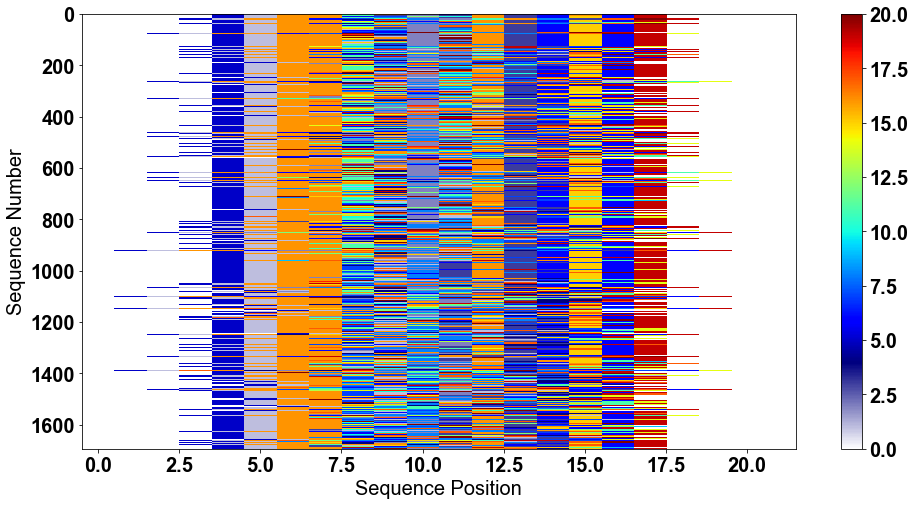

In [7]:
#################################
# The "align" option only changes alignments for Ig, not MSA encodings
align = 'center'
# This "pad" value only changes things if your alignemnt is "bulge"
# Otherwise keep it defined as 8, again another dummy variable that you need to keep
pad = 8
#################################

if molecule.lower() == 'ig':
    seq_MIpre = aims.gen_tcr_matrix(np.array(seqF),AA_key = my_AA_key,key=AA_num_key, giveSize = mat_size, alignment = align, bulge_pad=pad)
elif molecule.lower() == 'peptide':
    seq_MIpre = aims.gen_tcr_matrix(np.array(seqF),AA_key = my_AA_key,key=AA_num_key, giveSize = mat_size, alignment = align, bulge_pad=pad)
elif molecule.lower() == 'msa':
    AA_num_key_dash = np.hstack((AA_num_key,[0]))
    seq_MIpre = aims.gen_MSA_matrix(np.array(seqF),AA_key_dash = my_AA_key_dash, key = AA_num_key_dash, giveSize = mat_size)

seq_MIf = pandas.DataFrame(np.transpose(seq_MIpre),columns = seqF.columns)

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x = ax[0,0].imshow(np.transpose(seq_MIf), interpolation='nearest', aspect='auto',cmap=cmap)
ax[0,0].set_ylabel('Sequence Number')

######
# It will help to have vertical dashed black lines to guide the viewer
seq1_len = np.shape(seqF)[1]
Numclones = int(seq1_len)
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(Numclones),np.arange(Numclones),'k--',linewidth = 3)
#######
ax[0,0].set_xlabel('Sequence Position')

pl.colorbar(x)
pl.savefig(outputDir+'/AIMS_mat.pdf',format='pdf')

# Section 3: Calculate our Biophysical Property Matrices
Depending on what type of analysis you are doing, this will likely be the slowest step in this entire notebook

The only thing that you *might* need to change in the below code is the decision to normalize the biophysical properties or not. Default is to normalize

# <font color='red'>NOTE: RENORMALIZATION IS A *VERY* IMPORTANT NEW FEATURE </font>
This is a new step in our biophysical property matrix generation in AIMSv0.8. Whereas the standard "normalize" option simply scales all of our biophysical property features to norm 1 and mean 0, the "re-normalize" function is data-dependent. It reweights these normalized features to strongly focus attention to regions of high entropy. This is especially important in cases of large datasets (5000+ sequences) where certain features such as anchor regions in peptides or V- and J-gene germline encoded regions will dominate downstream clustering analysis

In [11]:
##################################################################################
# Process this new matrix and apply biophysical propery "masks"
# This has to be changed from the binary case, because we aren't looking for differences
normalize = True
dsetF = seqF.values
# Renormalize explicitly tries to make the higher entropy regions 
# more important in the matrix... 2**entropy
renormalize = True
###################################################################################

if molecule.lower() == 'ig':
    special = ''
elif molecule.lower() == 'peptide':
    special = ''
elif molecule.lower() == 'msa':
    special = 'MSA'

#################### PARALLEL PROCESSING TO CREATE BIG MATRIX #######################
if parallel_process:
    import multiprocessing as mp
    def boot_it(data):
        bigass = classy.get_bigass_matrix(dsetF[:,data[0]:data[1]], AA_key=my_AA_key,AA_key_dash=my_AA_key_dash,giveSize = mat_size, alignment = align,special = special, norm=normalize,bulge_pad=pad)
        return(bigass)
    def do_boot(data):
        with mp.Pool() as pool:
            results = pool.map(boot_it, data)
            return(results)
    if __name__ == "__main__":
        # Probably a smarter way to calculate #seqs per node, but do 100 for now
        final = aims.gen_splits(splitMat = seq_MIf, splitSize = 100)
        big_pre = do_boot(final)
    total_mat = np.concatenate(big_pre, axis = 0)
else:
    #################### Or, Don't Parallelize to CREATE BIG MATRIX #######################
    bigass = classy.get_bigass_matrix(dsetF,AA_key=my_AA_key,AA_key_dash=my_AA_key_dash, giveSize = mat_size, alignment = align, norm = normalize,special=special,bulge_pad=pad )
    total_mat = bigass
    
# Generate a large list of property names and matrix positions so you can pinpoint strong
# contributors to discrimating features between datasets or clusters
prop_list_old = ['Phobic1','Charge','Phobic2','Bulk','Flex','Kid1','Kid2','Kid3','Kid4','Kid5','Kid6','Kid7','Kid8','Kid9','Kid10']
prop_list_new = ['Hot'+str(b+1) for b in range(46)]
prop_names = prop_list_old + prop_list_new
num_locs = int(np.shape(total_mat)[1]/61)
Bigass_names = []
for i in prop_names:
    for j in np.arange(num_locs):
        Bigass_names = Bigass_names + [ i + '-' + str(j) ]

########################################################################################
if renormalize:
    entropy_pre,freq_pre,cov_pre = aims.calculate_shannon(np.transpose(seq_MIf.values))

    repeat_ent = []
    for i in np.arange(len(prop_names)):
        repeat_ent = repeat_ent + [2**entropy_pre]

    refactor = np.array(repeat_ent).reshape(61*len(entropy_pre))

    pp_mat = total_mat*refactor
else:
    pp_mat = total_mat
##########################################################################################
# Drop Highly Correlated Vectors and Vectors where entry=0 for all entries
###### Currently drop vectors with over 0.75 corr. coef. ################
full_big = pandas.DataFrame(pp_mat,columns = Bigass_names)
drop_zeros = [column for column in full_big.columns if all(full_big[column] == 0 )]
y = full_big.drop(full_big[drop_zeros], axis=1)
z_pre = np.abs(np.corrcoef(np.transpose(y)))
z = pandas.DataFrame(z_pre,columns=y.columns,index=y.columns)
# Select upper triangle of correlation matrix
upper = z.where(np.triu(np.ones(z.shape), k=1).astype(bool))
# If you did want to change that corr. coef. cutoff, do so here
to_drop = [column for column in upper.columns if ( any(upper[column] > 0.75) ) ]

# Your final product of a parsed matrix
parsed_mat = y.drop(y[to_drop], axis=1)

# This is a new, important variable to account for the cases where renormalization
# is used. We need non-renormed data for downstream repertoire characterization
NonNorm_big = pandas.DataFrame(total_mat,columns = Bigass_names)

# Let's have some default metadata we can pull from later
tokenized_dset = []
for i in np.arange(len(datName)):
    for j in seqF.columns:
        if str(j).find(datName[i]) != -1:
            tokenized_dset.append(i)
token_df = pandas.DataFrame(tokenized_dset,columns=['ID'])
IDed_full_big = pandas.concat([full_big,token_df],axis=1)

# Lastly, create a good-ole traditional averaged bphys property matrix
# i.e. each sequence gets a single value for averaged charge, averaged flexibility, etc...
posLen,seqLen = np.shape(seq_MIf)
# The 61 is hardcoded here because it is our number of properties. Eventually we will let users define which properties to use
seq_bigReshape = np.array(full_big).reshape(seqLen,61,posLen)

# Section 4: Sequence Projection & Clustering

# The next few cells are particularly powerful for isolating interesting populations in the dataset using PCA, UMAP, and KMeans Clustering

This is really a section where you should take your time and toggle some of these settings. Look at your data using PCA and UMAP

Try to use "full", "parse", or "avg" biophysical properties for each entry as input into the dimensionality reduction 

The below cell is important to define, so we set it apart from the rest of the code

In [12]:
# DEFINE WHICH FORM OF THE DATASET YOU WOULD LIKE TO ANALYZE HERE
# Perform dim. red. on the whole dataset? enter "full"
# Want to do it on a dataset with highly correlated vectors removed? enter "parse"
# Lastly, can just do it on a matrix of the per-sequence average over 61 props? enter "avg"
###################################################################################
# enter "full", "parse", or "avg"
dchoice = 'parse'

# Then, choose which dimensionality reduction and clustering method you want to use
# Want to run pca or umap?
reduce = 'umap'
# What will you cluster with (kmean, optics, dbscan)?
clust = 'dbscan'
###################################################################################

# The below section then uses the above information to actually calculate these things

There is a lot of opportunity to go EVEN deeper into the code here to tweak your analysis. Important to do if you really care about the data. Alter things like:
- Nclust for Kmeans
- min_samples for OPTICS
- eps for DBSCAN
- Setting random seeds for UMAP (see the ReadTheDocs for the disclaimer for using UMAP)

In [13]:
# Don't change these if statements, change the stuff below that
if dchoice.lower() == 'full':
    chosen_dset = full_big
elif dchoice.lower() == 'parse':
    chosen_dset = parsed_mat
elif dchoice.lower() == 'avg':
    chosen_dset = np.average(seq_bigReshape,axis=2)

if reduce == 'pca':
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3, svd_solver='full')
    final=pca.fit_transform(chosen_dset)
    transform = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)
    print("PCA Explained Variance Ratio:")
    print(pca.explained_variance_ratio_)
elif reduce == 'umap':
    import umap
    reducer = umap.UMAP(n_components=3, n_neighbors = 25,random_state=617)
    final = reducer.fit_transform(chosen_dset)
    transform = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)

# Cluster the results:
import sklearn.cluster as cluster
clust_input = np.array(np.transpose(transform))
if clust == 'kmean':
    NClust = 3
    clusts = cluster.KMeans(n_clusters=NClust).fit_predict(clust_input)
elif clust == 'optics':
    clusts = cluster.OPTICS(min_samples=10).fit_predict(clust_input)
elif clust == 'dbscan':
    clusts = cluster.DBSCAN(eps=0.15).fit_predict(clust_input)
elif clust == 'hdbscan':
    clusts = cluster.HDBSCAN(min_cluster_size = 250).fit_predict(clust_input)

cluster_dset = pandas.DataFrame(clusts,columns=['cluster'])

# SECTION 5: Metadata Incorporation

By default, we'll assume that the user DOES NOT have any metadata to add (and the code reflects this), but there are sections to show how metadata could be incorporated are included in the code. The ReadTheDocs will be updated soon to go into more detail here for you to add custom metadata

In [14]:
# We can incorporate metadata either defining a categorical map or a quantitative map
###################################################################################
# meta_form is either "category" or "quant". Check ReadTheDocs if more descriptions are needed
# If using default metadata (i.e. loaded file), it should be "category"
meta_form = 'category'
# GOT META SHOULD BE TRUE ONLY IF YOU HAVE A FILE LIKE "VDJDB META PARSE"
gotMeta = False
###################################################################################

if meta_form == 'category':
    if gotMeta:
        ###################################################################################
        # This is an example of how to load in your own metadata
        # Your # metadat entries should match your # sequence entries
        metapre = pandas.read_csv(datDir+'/vdjdb_meta_parse.csv')
        metapre.index = compile_index
        meta = metapre.loc[compile_index]
        # A bunch of columns to choose from. Note though, you can
        # only visualize one at a time in the current version
        metadat = pandas.DataFrame(meta['antigen.species'])
        metadat.columns = [0]
        ###################################################################################
    else:
        ###################################################################################
        # This is the easiest default metadata definition.
        # Just based on the files that were loaded in (useless if only 1 file)
        metapre = token_df
        # Convert the metadata from numbers to strings
        meta_conv = []
        for i in token_df.values:
            meta_conv.append(datName[i[0]])
        metadat = pandas.DataFrame(meta_conv)
        ###################################################################################
elif meta_form == 'quant':
    # QUANTITATIVE METADATA IS NOT READY YET! ON THE TO-DO!
    # This "quantitative" metadata will just count from 1 to the length of the dataset,
    # coloring the points on the plot in order.
    metaPRE = np.arange(len(token_df))
    metadat = pandas.DataFrame(metaPRE)
    # But, you could add things like MFI, binding affinity, or GEX data for a particular gene

# From there, not much should change unless you want to give a unique name to your metadata
meta_name = 'meta'
meta_map = aims.encode_meta(metadat)
meta_map.columns = [meta_name]
meta_leg = metadat.drop_duplicates().values

# We also need to define our clusters more clearly
clust_map = cluster_dset
clust_leg = [a[0] for a in cluster_dset.drop_duplicates().sort_values('cluster').values]
clust_name = 'cluster'

# Section 6: Plotting Clustering and (Optional) Metadata
The previous section was just for calculating these things. We are now going to provide users with a few different options to visualize their data

By default we show 2D and 3D cluster projections with metadata and clustered data but give users control over which is shown

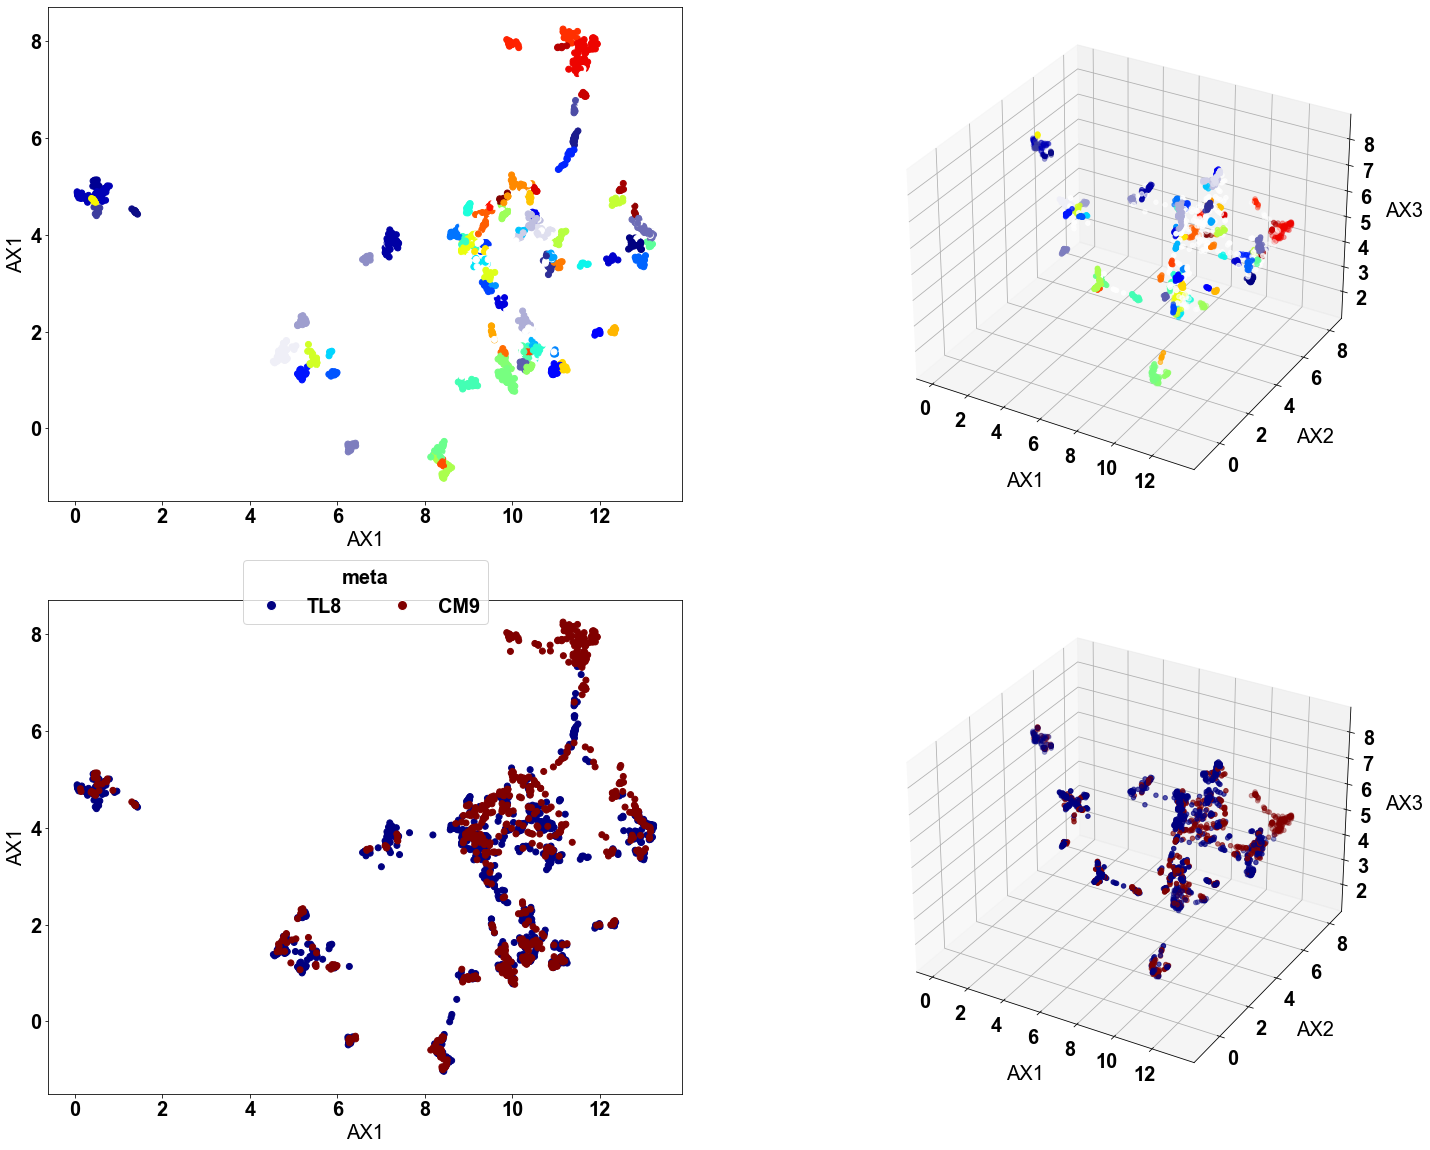

In [15]:
######### Do you want to show 2D projection, 3D, or both?##################
proj_show = 'both'
##########################################################################
######### What about clusters, metadata, or both?##################
clust_show = 'both'
##########################################################################
######### Optionally show labels to identify outlier sequences or sequences of interest##################
# NOTE that these labels really only work well with very few datapoints. Future updates will try to
# work around this issue a little bit better...
show_labels = False
# Could optionally plot other data or change legends if you would like
chosen_map1 = clust_map; leg1 = clust_leg
chosen_map2 = meta_map; leg2 = meta_leg

# Define a colormap to color metadata. Can change this if you want, look at matplotlib colormap options
# BUT NOTE, if your colormap is discrete, you can get repetitive colors in the plot if #meta_unique > #colors
cmapF = pl.get_cmap('jet')
# So there's no reason to have a function for this, other than to make this notebook look a bit prettier
# Really just defining a bunch of stuff repeatedly with if statements
fig3d,plotloc,plottype,plotem,legends,dattype = aims.get_plotdefs(clust_show,proj_show,chosen_map1,chosen_map2,leg1,leg2)

# Now plot the actual stuff, and save the object handles in a list
colorhandle= []; ax=[]
for i in np.arange(len(plotloc)):
    if dattype[i] == 'clust':
        if clust == 'kmean':
            cmap_use = pl.get_cmap('Pastel1')
        else:
            cmap_use = cmap
    else:
        cmap_use = cmapF
    if plottype[i] == '3d':
        ax.append(fig3d.add_subplot(plotloc[i],projection=plottype[i]))
        # So the 3D plot has shading, which means instead we're better off splitting the data up 
        colorhandle.append(ax[i].scatter(clust_input[:,0],clust_input[:,1],clust_input[:,2],c = plotem[i].values.reshape(len(plotem[i]),), cmap=cmap_use))
        ax[i].set_xlabel('AX1',labelpad=20); ax[i].set_ylabel('AX2',labelpad=20); ax[i].set_zlabel('AX3',labelpad=15)
    else:
        ax.append(fig3d.add_subplot(plotloc[i]))
        colorhandle.append(ax[i].scatter(clust_input[:,0],clust_input[:,1],c = plotem[i].values.reshape(len(plotem[i]),), cmap=cmap_use))
        ax[i].set_xlabel('AX1'); ax[i].set_ylabel('AX1')

# This code is somewhat wild just for getting a properly color-coded legend in there...
fig3d.canvas.draw()
# We use the metadata mapped colors down the line, so if you aren't plotting it then you need to save some other way
need_meta = True
for i in np.arange(len(legends)):
    cmap_pre = pandas.DataFrame(colorhandle[i].get_facecolors())
    if dattype[i] == 'clust':
        mapDF = pandas.concat([clust_map,cmap_pre],axis=1)
        mapped_colors= mapDF.sort_values('cluster').drop_duplicates('cluster').values[:,1:]
    else:
        mapDF = pandas.concat([meta_map,cmap_pre],axis=1)
        mapped_colors= mapDF.sort_values('meta').drop_duplicates('meta').values[:,1:]
        keep_map = mapped_colors
    # Do two things at once here. Also add in axis labels
    # Don't plot duplicate legends
    if i > 0:
        if dattype[i] == dattype[i-1]:
            continue
    if len(legends[i]) > 6:
        # Don't show exceedingly long legends
        continue
    else:
        legend_elements = []
        # This line won't do anything if the array is properly shaped, will do stuff it if isn't.
        legends[i] = np.array(legends[i]).reshape(len(legends[i]))
        for j in np.arange(len(legends[i])):
            element = [Line2D([0], [0], marker='o', color='w', label=legends[i][j],markerfacecolor=mapped_colors[j], markersize=10)]
            legend_elements = legend_elements+element
        ax[i].legend(bbox_to_anchor=(0.5, 1.1),handles=legend_elements,loc='upper center',ncol=len(legends[i]),title=meta_name)

if need_meta:
    cmap_discrete = cmapF(np.linspace(0, 1, len(meta_map.drop_duplicates())))
    cmap_pre = pandas.DataFrame(cmap_discrete)
    mapDF = pandas.concat([meta_map.drop_duplicates().reset_index(),cmap_pre],axis=1)
    mapped_colors= mapDF.sort_values('meta').drop_duplicates('meta').values[:,2:]
    keep_map = mapped_colors


if show_labels:
    # ONLY show this for a 2D plot
    for num in np.arange(len(ax)):
        if plottype[num] == '2d':
            break
    a = 0; plot1 = clust_input[:,0]; plot2 = clust_input[:,1]
    plot_labels = seqF.columns.values
    for i,j in zip(plot1,plot2):
        ax[num].annotate(str(plot_labels[a]),xy=(i,j),fontsize=14)
        a+=1
    
pl.savefig(outputDir+'/AIMS_projections.pdf',format='pdf')
pl.show()

# Section 7: Quantify Cluster Compositions
This step might be meaningless if you don't have ANY metadata to go off of, and/or are not comparing/contrasting two datasets. This is fine, you should still run this step to make sure that everything is properly defined


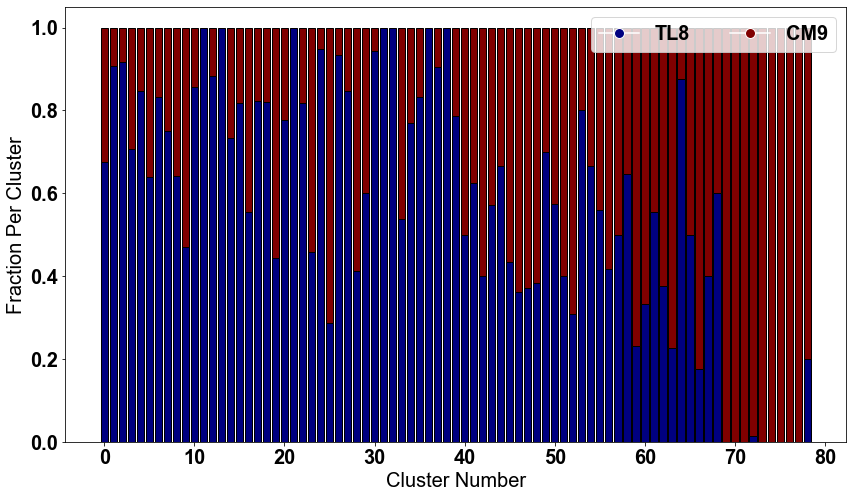

In [16]:
#########################
# Do you want to noramlize these bar plots or no?
norm = True
#########################

cmap3 = pl.get_cmap('tab20b')
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,8))
# Just in case your metadata has weird indices:
meta_map.index = cluster_dset.index
final_breakdown = pandas.concat([cluster_dset,meta_map],axis=1)
a = 0
for i in np.sort(final_breakdown['cluster'].drop_duplicates()):
    if i == -1:
        continue # Dont count the unclustered
    sub_clust = final_breakdown[final_breakdown['cluster'] == i]
    if len(sub_clust) == 0:
        continue
    bottom=0

    for j in sub_clust[meta_name].drop_duplicates().values:
        sub_sub = sub_clust[sub_clust[meta_name] == j]
        if norm:
            pl.bar(a,len(sub_sub)/len(sub_clust),bottom = bottom,color=keep_map[int(j)],edgecolor='black')
            bottom += len(sub_sub)/len(sub_clust)
        else:
            pl.bar(a,len(sub_sub),bottom = bottom,color=keep_map[int(j)],edgecolor='black')
            bottom += len(sub_sub)
    a = a+1

meta_legF = np.array(meta_leg).reshape(len(meta_leg))
if len(meta_leg) < 6:
    legend_elements= []
    for j in np.arange(len(meta_leg)):
        element = [Line2D([0], [0], marker='o', color='w', label=meta_legF[j],markerfacecolor=keep_map[j], markersize=10)]
        legend_elements = legend_elements+element
    pl.legend(handles=legend_elements,ncol=len(meta_leg))
pl.xlabel('Cluster Number')
if norm:
    pl.ylabel('Fraction Per Cluster')
else:
    pl.ylabel('Count Per Cluster')

pl.savefig(outputDir+'/AIMS_clusterQuant.pdf',format='pdf')

# Section 7.1: Calculating Cluster Purity
With new update (AIMS 0.8) we now have statistical quantifications for most outputs. However, these cluster purity calculations are somewhat slow to run. If users do not have interesting metadata, you may not want to run this step. Outputs generated here are not used elsewhere in the notebook

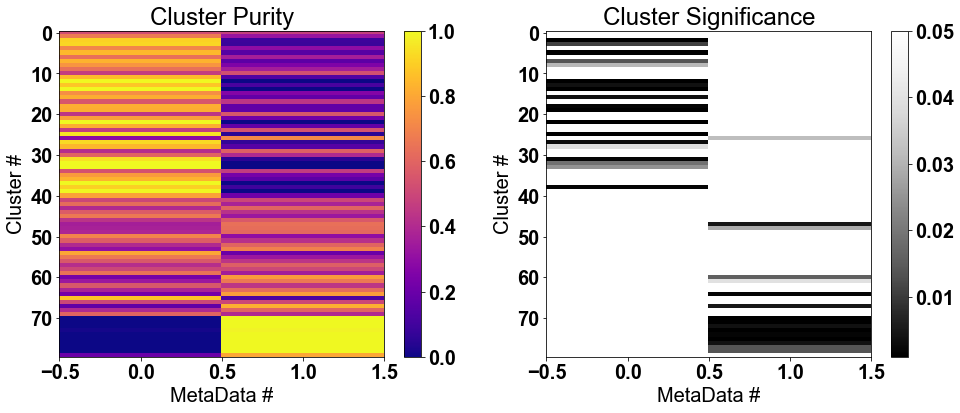

In [17]:
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(16,6))

cluster_purity,purity_pVal = aims.calc_cluster_purity(final_breakdown,meta_name)

x = ax[0,0].imshow(cluster_purity,interpolation='nearest', aspect='auto',vmax = 1,cmap='plasma')
y = ax[0,1].imshow(purity_pVal,interpolation='nearest', aspect='auto',vmax = 0.05,cmap='Greys_r')

ax[0,0].set_xlabel('MetaData #'); ax[0,1].set_xlabel('MetaData #')
ax[0,0].set_ylabel('Cluster #'); ax[0,1].set_ylabel('Cluster #')
ax[0,0].set_title('Cluster Purity'); ax[0,1].set_title('Cluster Significance')
pl.colorbar(x,ax=ax[0,0]); pl.colorbar(y,ax=ax[0,1])

pl.savefig(outputDir+'/AIMS_clusterPurity.pdf',format='pdf')

# Section 8: Defining Data Subsets of Interest to Further Characterize Repertoire
VERY IMPORTANT STEP here for all downstream analysis. Define whether you want to compare/contrast clustered sequences or analyze sequences based upon the associated metadata

# Note, if you load in two separate files, and want to compare those full repertoires in downstream analysis, you need to make sure you define your metadata to be the input filename (in the above steps)

In [18]:
# Decide if you want to analyze the data by cluster or by metadata.
subset_sel = 'metadata' # other option is 'cluster'

# Then, Plot This Dataset of Interest and Visualize How Similar/Different Each Look

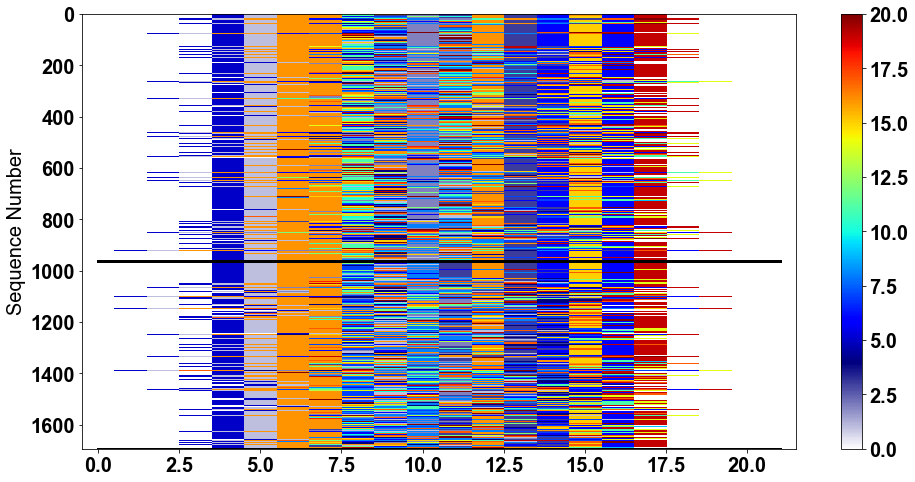

In [19]:
# NEW FEATURE!!!
# You can view biophysical properties as
# a function of cluster or metadata here,
# rather than just the sequence colors
#########################################
plot_props = False
# Recommend changing colors if showing diff props
showProp = 1 #1=Charge, 2=phob
# Show lines separating major groups?
show_lines = True
#########################################

if subset_sel.lower() == 'cluster':
    chosen_map = clust_map; chosen_name = clust_name
elif subset_sel.lower() == 'metadata':
    chosen_map = meta_map; chosen_name = meta_name
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
for i in np.sort(chosen_map[chosen_name].drop_duplicates()):
    if i == -1:
        continue
    if plot_props:
        sub_props = seq_bigReshape[:,showProp]
        subbDF = pandas.DataFrame(np.transpose(sub_props))
        subbDF.columns = seq_MIf.columns
        pre_clust = subbDF[subbDF.columns[chosen_map[chosen_map[chosen_name] == i].index]]
    else:
        pre_clust = seq_MIf[seq_MIf.columns[chosen_map[chosen_map[chosen_name] == i].index]]
    clustID = np.transpose(pandas.DataFrame(i*np.ones(np.shape(pre_clust)[1])))
    clustID.columns = pre_clust.columns
    pre_clustF = pandas.concat([pre_clust,clustID],axis=0)
    if i == 0:
        clustered = pre_clustF
    else:
        clustered = pandas.concat([clustered, pre_clustF],axis = 1)
    if show_lines:
        ax[0,0].plot(np.arange(len(seq_MIf)),np.ones(len(seq_MIf))*(np.shape(clustered)[1]),'black',linewidth = 3)
ax[0,0].set_ylabel('Sequence Number')
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(np.shape(clustered)[1]),np.arange(np.shape(clustered)[1]),'k--',linewidth = 3)
if plot_props:
    ttt = np.transpose(np.array(clustered))[:,:-1]
    scaledd = np.max([np.abs(np.min(ttt)),np.abs(np.max(ttt))])
    xyz = ax[0,0].imshow(np.transpose(np.array(clustered))[:,:-1], interpolation='nearest', aspect='auto',cmap='bwr',vmin=-scaledd,vmax=scaledd)
else:
    xyz = ax[0,0].imshow(np.transpose(np.array(clustered))[:,:-1], interpolation='nearest', aspect='auto',cmap=cmap)
pl.colorbar(xyz)
pl.savefig(outputDir+'/AIMS_'+subset_sel+'_subViz.pdf',format='pdf')

# Can Optionally Quantitatively Assess How Biophysically Similar These Clusters Are
Steal a page from the TCRdist software [Dash et al. Nat. Lett. 2017] from Paul Thomas' lab.

Use distance as a metric to quantify TCR similar. Our distance metric is a little different (literal Euclidean distance in AIMS-encoded space), but it correlates well with the established TCRdist metric.

# AIMSdist is now parallelizable!
With 15000 total sequences, processing took 15 minutes (on 36 cores, a pretty large machine). Might be able to optimize further.
I quit the non-parallel calculation after 80 minutes... parallel is much more efficient.

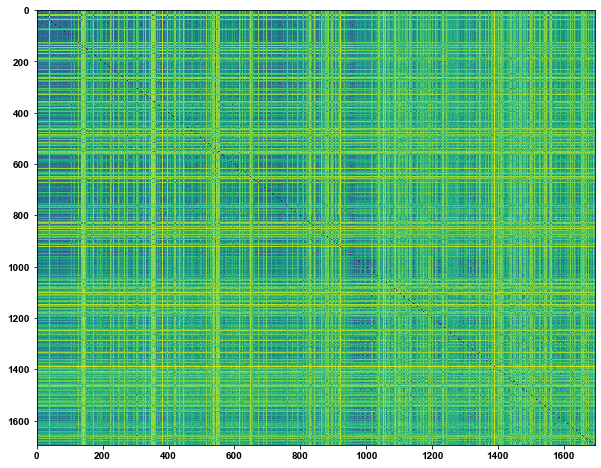

In [16]:
parallel_dist = True
get_distClusts = False

for i in chosen_map.sort_values(chosen_name).drop_duplicates().values:
    if i == -1:
        continue
    sub_MI_temp = seq_MIf[seq_MIf.columns[chosen_map[chosen_map[chosen_name] == i[0]].index]]
    sub_seqs_temp = np.transpose(seqF[sub_MI_temp.columns])
    if i == 0:
        sorted_seqs = sub_seqs_temp
    else:
        sorted_seqs = pandas.concat([sorted_seqs,sub_seqs_temp])
########################################################################################################3
if parallel_dist:
    import multiprocessing as mp
    def boot_it(data):
        if data[0][0] == data[1][0]:
            dist_temp = aims.calc_AIMSdist(sorted_seqs[data[0][0]:data[0][1]])
        else:
            dist_temp = aims.calc_AIMSdist(sorted_seqs[data[0][0]:data[0][1]],sorted_seqs[data[1][0]:data[1][1]])
        return(data,dist_temp)
    def do_boot(data):
        with mp.Pool() as pool:
            results = pool.map(boot_it, data)
            return(results)
    if __name__ == "__main__":
        # Probably a smarter way to calculate #seqs per node, but do 100 for now
        xx = aims.prep_distCalc(sorted_seqs)
        dist_pre = do_boot(xx)
    dist_matF = np.zeros((len(sorted_seqs),len(sorted_seqs)))
    for i in np.arange(len(dist_pre)):
        # Set 1 will be our x-axis of the matrix
        # set 2 will be our y-axis of the matrix
        set1 = dist_pre[i][0][0]
        set2 = dist_pre[i][0][1]
        # Set 3 is then the data that goes in that space
        set3 = dist_pre[i][1]

        # Need to fill both the matrix entry and the 
        # transpose of that entry!!!
        dist_matF[set1[0]:set1[1],set2[0]:set2[1]] = set3
        dist_matF[set2[0]:set2[1],set1[0]:set1[1]] = np.transpose(set3)
    dists = dist_matF
else:
    dists = aims.calc_AIMSdist(sorted_seqs)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(10,8))
x = pl.imshow(np.transpose(dists), interpolation='nearest', aspect='auto',vmin=0,vmax=11)

# Optionally can get back distance clusters:
if get_distClusts:
    distance_clusters = aims.get_distClusts(dists,metadat,max_d=5)

#pl.colorbar(x)

#pl.savefig(outputDir+'/AIMSdist.pdf',format='pdf')

# Section 9: Isolation of Individual Groups for Downstream Characterization
Run the next cell to visualize your clusters of choice, and then go through the remainder of the AIMS modules

Selecting the sub_sels [0,1] will select either the first two clusters or the first two metadata entries. Remember that python is 0-indexed, so if you want to look at a very specific metadata cluster then make sure you take that into account! You can *technically* visualize every cluster all at once, but that is REALLY not recommended

Visualizing the subsets: ['TL8', 'CM9']


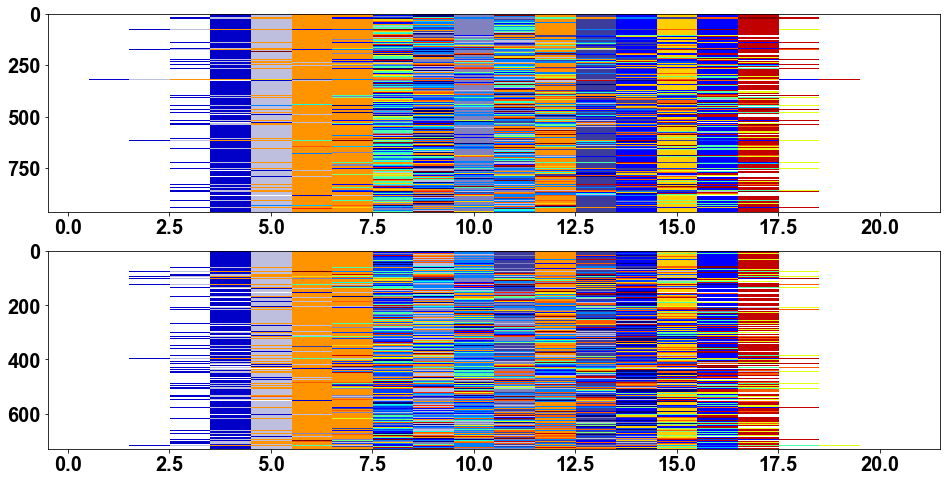

In [20]:
# So now that we've done some clustering, pick out the most interesting or sections of the data:
# You can technically pick out more than two, if desired, but some things may get wonky
sub_sels = [0,1]

# Do you want to save each individual cluster of sequences as an AIMS-compatible file?
seqlogo = False; save_subSeqs = False
# OPTIONALLY YOU CAN VISUALIZE/ANALYZE EVERY CLUSTER. STRONGLY NOT RECOMMENDED IF YOU HAVE MANY CLUSTERS
##sub_sels = np.arange(len(chosen_map))

# Redefine the raw sequences so we can manipulate them if needed
dset = seqF
fig, ax = pl.subplots(len(sub_sels), 1,squeeze=False,figsize=(16,4*len(sub_sels)))
label=[]
a = 0
for i in sub_sels:
    # Look at umap dset or pca dset
    sub_MI = seq_MIf[seq_MIf.columns[chosen_map[chosen_map[chosen_name] == i].index]]
    sub_seqs = np.transpose(dset[sub_MI.columns])
    if subset_sel.lower() == 'metadata':
        label.append(meta_legF[i])
    else:
        label.append('cluster'+str(i))
    ax[a,0].imshow(np.transpose(sub_MI), interpolation='nearest', aspect='auto',cmap=cmap)

    datlen = np.shape(sub_MI)[1]
    datID = np.transpose(pandas.DataFrame(datlen*[a]))
    datID.columns = sub_MI.columns
    sub_matPRE = pandas.concat([sub_MI,datID],axis=0)
    if a == 0:
        sub_matF = sub_matPRE
        sub_seqF = sub_seqs
    else:
        sub_matF = pandas.concat([sub_matF,sub_matPRE],axis=1)
        sub_seqF = pandas.concat([sub_seqF,sub_seqs],axis=0)
    a+=1 

    if save_subSeqs:
        sub_seqs.to_csv(outputDir+'/'+label[i]+'_all.txt',header=None,index=None)
    if seqlogo:
        seqlogo1 = sub_seqs[sub_seqs[0].str.len() == 14]
        seqlogo1.to_csv(outputDir+'/'+label[i]+'_logo.txt',header=None,index=None)

print("Visualizing the subsets: "+str([str(a) for a in label]))
pl.savefig(outputDir+'/AIMS_'+subset_sel+'_selected.pdf',format='pdf')

# Leaving This Here in Case You Have Seqlogo Installed
Can be useful to visualize some sequences in this way. This code has not been tested in a while, and has not been tested at all for MSA analysis

In [18]:
%%bash
# Alright let's cheat and just use the seqlogo in bash... the python script is a little bit of a pain.
# Code is from reference: 
#Crooks GE, Hon G, Chandonia JM, Brenner SE WebLogo: A sequence logo generator, Genome Research, 14:1188-1190, (2004)

# Obviously, change this path to wherever YOUR seqlogo is and whatever your filename is
#weblogo/seqlogo -F PDF -c -n -Y -f sub1_logo.txt > sub1_logo.pdf

# Section 10: Generate Subsets of Matrices We Have Calculated Previously
This will save some time compared to how things were done before.

In [21]:
# define "RE" variables so we don't mess with any variables upstream (in case you want to re-run)
full_big_re = NonNorm_big; full_big_re.index = seq_MIf.columns
parsed_mat_re = parsed_mat; parsed_mat_re.index = seq_MIf.columns
# use the transpose of the sub_mat to find the 
ref_sub = np.transpose(sub_matF)
ref_sub.columns = np.arange(len(sub_matF))

sub_big = full_big_re.loc[sub_matF.columns]
sub_parsed = parsed_mat_re.loc[sub_matF.columns]

# Section 11: Position Sensitive Biophysical Properties for Every Clone in the Dataset
Here, we can visualize the how similar or dissimilar the biophysical properties are for each sequence within a given repertoire.

Right now we show only the charge and the hydropathy, but you can change "prop1" in either cell to visualize a different property (see ReadTheDocs for more info)

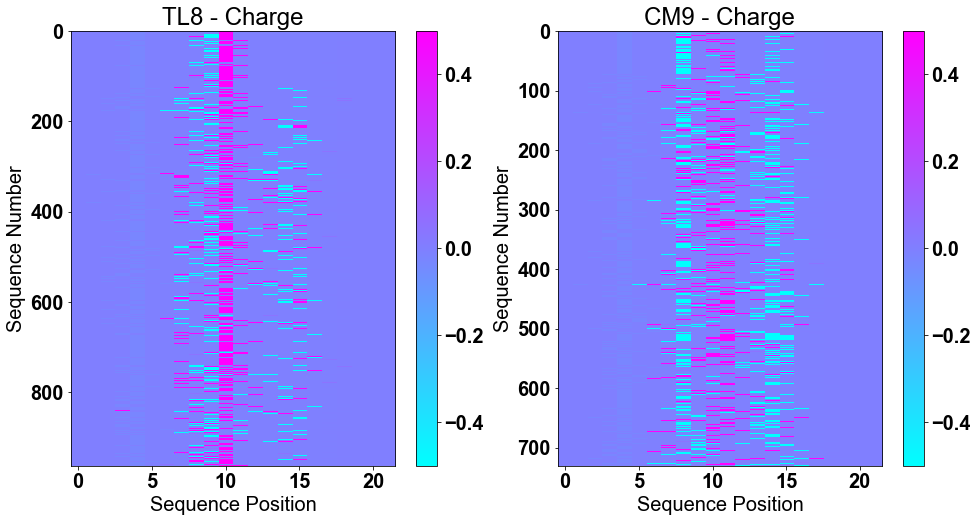

In [22]:
# Generate the position sensitive charge across all clones in the dataset
# Which property will you want to look at down the line? 1 = charge, 2 = hydrophobicity... see full list in eLife paper (Boughter et al. 2020)
prop1 = 1

fig, axs = pl.subplots(1, len(sub_sels),squeeze=False,figsize=(8*len(sub_sels),8))

for dat in np.arange(len(sub_sels)):
    take_sub = ref_sub[ref_sub[len(sub_matF)-1] == dat].index
    take_big = sub_big.loc[take_sub]
    temp_bigReshape = np.array(take_big).reshape(len(take_big),61,posLen)
    x = axs[0,dat].imshow(temp_bigReshape[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.cool, vmin = -0.5, vmax = 0.5)
    axs[0,dat].set_xlabel('Sequence Position'); axs[0,dat].set_ylabel('Sequence Number')
    axs[0,dat].set_title(str(label[dat]) + ' - Charge')
    fig.colorbar(x, ax=axs[0,dat])

pl.savefig(outputDir+'/AIMS_'+subset_sel+'_charge.pdf',format='pdf')

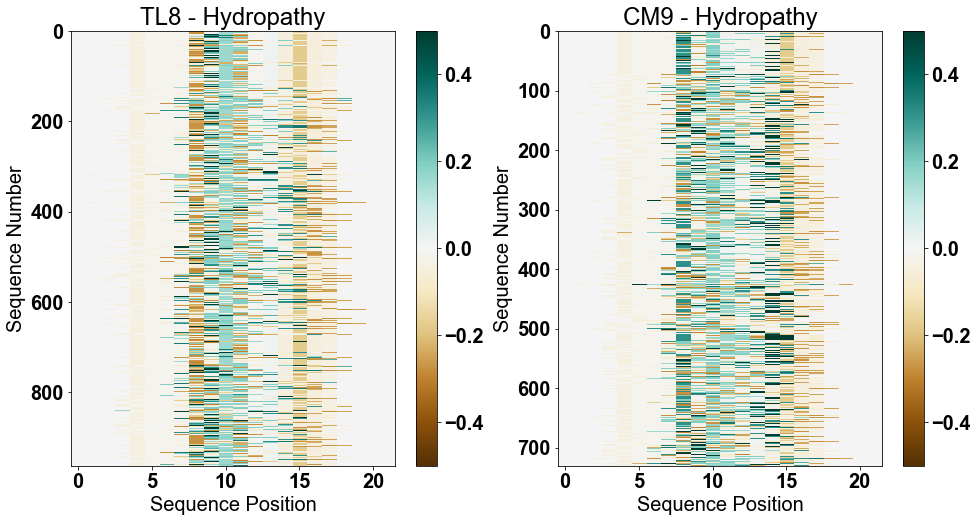

In [23]:
# Do the same thing again for hydropathy
prop1 = 2
fig, axs = pl.subplots(1, len(sub_sels),squeeze=False,figsize=(8*len(sub_sels),8))

for dat in np.arange(len(sub_sels)):
    take_sub = ref_sub[ref_sub[len(sub_matF)-1] == dat].index
    take_big = sub_big.loc[take_sub]
    temp_bigReshape = np.array(take_big).reshape(len(take_big),61,posLen)
    x = axs[0,dat].imshow(temp_bigReshape[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.BrBG, vmin = -0.5, vmax = 0.5)
    axs[0,dat].set_xlabel('Sequence Position'); axs[0,dat].set_ylabel('Sequence Number')
    axs[0,dat].set_title(str(label[dat]) + ' - Hydropathy')
    fig.colorbar(x, ax=axs[0,dat])

pl.savefig(outputDir+'/AIMS_'+subset_sel+'_hydropathy.pdf',format='pdf')

# Section 12: Averaged Biophysical Properties for Each Group of Interest
Look at biophysical properties averaged over clones AND position

Note for old users of the software, you might get different looking results because originally I normalized vectors to unit length, but NOT 0 mean. I now do both.

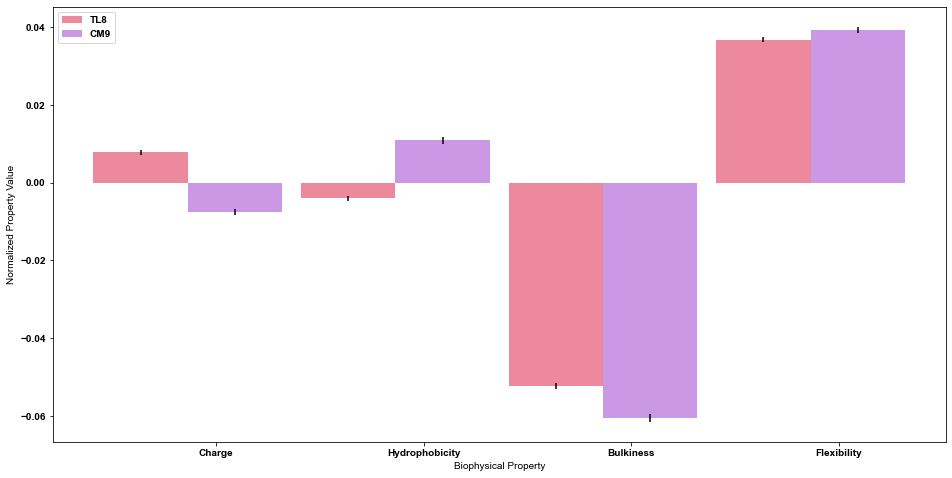

In [22]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x_axis = np.array([-0.2,0.9,2,3.1])
# We want to exclude prop0 (the simple 1-21 AA representation entries)

colors= ['Crimson','darkorchid']

####################################################################
# New for version 0.8! Add stdev based on boostrapping procedures
bootstrap = True
boots = 1000
####################################################################

full_avg = []; full_std = []; plot_lab = []
a=0
for dat in np.arange(len(sub_sels)):
    sin_avg =[]; sin_std = []
    b=0
    for prop in np.arange(4):
        propF = prop+1
        take_sub = ref_sub[ref_sub[len(sub_matF)-1] == dat].index
        take_big = sub_big.loc[take_sub]
        temp_bigReshape = np.array(take_big).reshape(len(take_big),61,posLen)
        if bootstrap:
            prop_avg = []
            for i in np.arange(boots):
                re_big = resample(temp_bigReshape)
                prop_avg.append(np.average(re_big[:,propF,:]))
            fin_avg = np.average(prop_avg,axis=0)
            fin_std = np.std(prop_avg,axis=0)
            if b == 0:
                plot_lab.append(pl.bar(x_axis[b]+a/len(sub_sels), fin_avg,yerr=fin_std,width=1/len(sub_sels),alpha=0.5,color=colors[dat]))
            else:
                pl.bar(x_axis[b]+a/len(sub_sels), fin_avg,yerr=fin_std,width=1/len(sub_sels),alpha=0.5,color=colors[dat])
        
        else:
            # We don't want to plot prop1, we want to plot the rest of them
            plot_avg = np.average(np.average(temp_bigReshape[:,propF,:],axis=1))
            plot_std = np.std(np.std(temp_bigReshape[:,propF,:],axis=1))
            sin_avg.append(plot_avg)
            sin_std.append(plot_std)
        b+=1
    a+=1

    if bootstrap == False:
        full_avg.append(sin_avg)
        full_std.append(sin_std)

if bootstrap == False:
    for i in np.arange(len(sub_sels)):
        ax[0,0].bar(x_axis+i/len(sub_sels), full_avg[i],yerr = full_std[i],alpha = 0.5, width = 1/len(sub_sels),color=colors[i])
        #ax[0,0].bar(x_axis+i/len(sub_sels), full_avg[i],alpha = 0.5, width = 1/len(sub_sels))
        ax[0,0].legend(label)
else:
    ax[0,0].legend(plot_lab,label)
ax[0,0].set_xticks([0.2,1.3,2.4,3.5])
ax[0,0].set_xticklabels(['Charge','Hydrophobicity','Bulkiness','Flexibility'])
ax[0,0].set_xlabel('Biophysical Property')
ax[0,0].set_ylabel('Normalized Property Value')
pl.savefig(outputDir+'/AIMS_'+subset_sel+'_netAvgProp.pdf',format='pdf')

# Section 12.1 Calculating Statistical Significance
Optional to run this section. Pretty fast for the above figure though. Future software versions will try to directly add asterisks to plots
ALSO note, while you can plot more than two datasets on the above plot, significance testing is currently only set up for two datasets.

In [23]:
prop_names = ['Charge','Hydrophobicity','Bulkiness','Flexibility']
take_sub1 = ref_sub[ref_sub[len(sub_matF)-1] == 0].index
take_big1 = sub_big.loc[take_sub1]
temp_bigReshape1 = np.array(take_big1).reshape(len(take_big1),61,posLen)
take_sub2 = ref_sub[ref_sub[len(sub_matF)-1] == 1].index
take_big2 = sub_big.loc[take_sub2]
temp_bigReshape2 = np.array(take_big2).reshape(len(take_big2),61,posLen)

# Significance for Bar plots
for i in np.arange(4):
    propF = i+1
    data1 = np.average(temp_bigReshape1[:,propF,:],axis=1)
    data2 = np.average(temp_bigReshape2[:,propF,:],axis=1)
    p = aims.do_statistics(data1,data2,num_reps=10000,test='average')
    print('p-value for '+prop_names[i]+' bar plot: '+str(p))

p-value for Charge bar plot: 9.999000099990002e-05
p-value for Hydrophobicity bar plot: 9.999000099990002e-05
p-value for Bulkiness bar plot: 9.999000099990002e-05
p-value for Flexibility bar plot: 0.0136986301369863


# Section 13: Position-Sensitive Averaged Biophysical Properties
Here we effectively average the figures from section 11 over the y-axes, giving a general idea of trends in the biophysical properties of within-group sequences

NOTE: This figure frequently looks chaotic/hard to parse for MSA analysis. More useful for Ig analysis

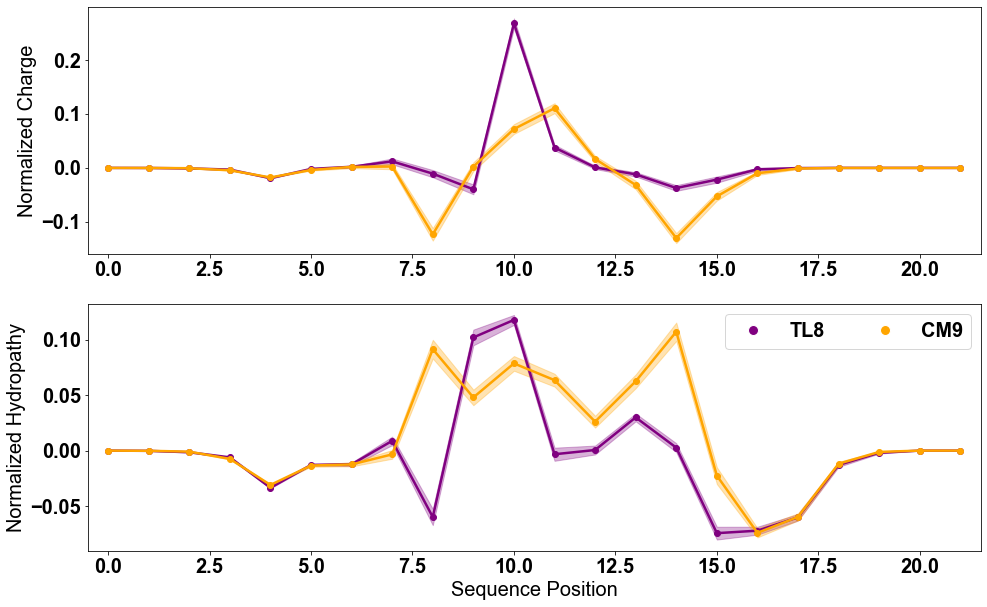

In [24]:
# Now get the position sensitive avarege biophysical properties
# DONT CHANGE THE FIGURE ASPECT RATIOS. AS-IS, IT SHOULD LINE UP VERY WELL WITH THE AIMS MATRIX VISUALIZATIONS
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(16,10))
prop_sel = [1,2]
full_avg = []; full_std = []
# These chaotic strings are the two first t
#colors=['#1f77b4', '#ff7f0e'] 
#colors = ['DarkSlateGrey','deepskyblue']
colors= ['purple','orange']

####################################################################
# New for version 0.8! Add stdev based on boostrapping procedures
bootstrap = True
boots = 1000
####################################################################

for dat in np.arange(len(sub_sels)):
    a=0
    for prop in prop_sel:
        take_sub = ref_sub[ref_sub[len(sub_matF)-1] == dat].index
        take_big = sub_big.loc[take_sub]
        temp_bigReshape = np.array(take_big).reshape(len(take_big),61,posLen)
        if bootstrap:
            prop_avg = []
            for i in np.arange(boots):
                re_big = resample(temp_bigReshape)
                prop_avg.append(np.average(re_big[:,prop,:],axis=0))
            fin_avg = np.average(prop_avg,axis=0)
            fin_std = np.std(prop_avg,axis=0)
            ax[a,0].plot(fin_avg,marker='o',linewidth=2.5,color=colors[dat])
            ax[a,0].fill_between(np.arange(len(fin_avg)),fin_avg+fin_std,fin_avg-fin_std,alpha=0.3,color=colors[dat])
        else:
            take_sub = ref_sub[ref_sub[len(sub_matF)-1] == dat].index
            take_big = sub_big.loc[take_sub]
            temp_bigReshape = np.array(take_big).reshape(len(take_big),61,posLen)
            plot_avg = np.average(temp_bigReshape[:,prop,:],axis=0)
            plot_std = np.std(temp_bigReshape[:,prop,:],axis=0)

            ax[a,0].plot(plot_avg,marker='o',linewidth=2.5,color=colors[dat])
            ax[a,0].fill_between(np.arange(len(plot_avg)),plot_avg+plot_std,plot_avg-plot_std,alpha=0.3,color=colors[dat])
        a+=1

# Draw some nice lines to guide 
y11, y12 = ax[0,0].get_ylim();y21, y22 = ax[1,0].get_ylim()
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y11,y12,100),'black',linewidth = 3)
        ax[1,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y21,y22,100),'black',linewidth = 3)

legend_elements=[]
for j in np.arange(len(sub_sels)):
    element = [Line2D([0], [0], marker='o', color='w', label=label[j],markerfacecolor=colors[j], markersize=10)]
    legend_elements = legend_elements+element
pl.legend(handles=legend_elements,ncol=len(sub_sels))

ax[0,0].set_ylabel('Normalized Charge')
ax[1,0].set_ylabel('Normalized Hydropathy')
if type(mat_size)==int:
    ax[0,0].set_xlim([-0.5,mat_size-0.5])
    ax[1,0].set_xlim([-0.5,mat_size-0.5])
else:
    ax[0,0].set_xlim([-0.5,sum(mat_size)-0.5])
    ax[1,0].set_xlim([-0.5,sum(mat_size)-0.5])

pl.xlabel('Sequence Position')
pl.savefig(outputDir+'/AIMS_posSensAvg.pdf',format='pdf')

# Section 13.1 Calculating Statistical Significance for Position-Sensitive Metrics
Again, this is a pretty fast calculation relatively speaking. Because we're testing each individual point, it is much easier to plot the results as a figure rather than printing the p-values. The red line below gives "significance" at p<0.05

Note, reviewers have pointed out that there should perhaps be some multiple-test correction here. That's a bit tricky to implement, because should we really count those padded-zero entries as true "tests"? Probably not... There is a multiple testing function but not yet automated to output as a plot. Working on it

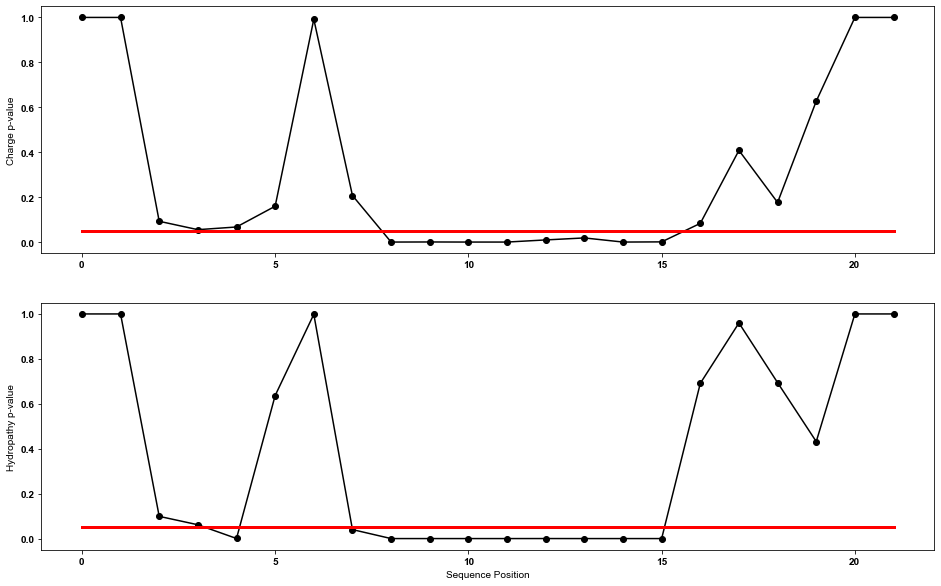

In [25]:
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(16,10))
take_sub1 = ref_sub[ref_sub[len(sub_matF)-1] == 0].index
take_big1 = sub_big.loc[take_sub1]
temp_bigReshape1 = np.array(take_big1).reshape(len(take_big1),61,posLen)
take_sub2 = ref_sub[ref_sub[len(sub_matF)-1] == 1].index
take_big2 = sub_big.loc[take_sub2]
temp_bigReshape2 = np.array(take_big2).reshape(len(take_big2),61,posLen)

a=0
for propF in prop_sel:
    #Significance for position-sensitive
    data1 = temp_bigReshape1[:,propF,:]
    data2 = temp_bigReshape2[:,propF,:]

    p = aims.do_statistics(data1,data2,num_reps=10000,test='average')
    ax[a,0].plot(p,color='black',marker='o')
    ax[a,0].plot(np.arange(np.shape(data1)[1]),np.ones(np.shape(data1)[1])*0.05,linewidth=3,color='red')
    a+=1

y11, y12 = ax[0,0].get_ylim();y21, y22 = ax[1,0].get_ylim()
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y11,y12,100),'black',linewidth = 3,linestyle='--')
        ax[1,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y21,y22,100),'black',linewidth = 3,linestyle='--')

pl.xlabel('Sequence Position')
ax[0,0].set_ylabel('Charge p-value')
ax[1,0].set_ylabel('Hydropathy p-value')
pl.savefig(outputDir+'/AIMS_PosSens_pval.pdf',format='pdf')

# Section 13.2: Calculating Dataset Sequence Coverage
Alright so one of the reviewers (correctly) pointed out that perhaps new users of AIMS might not immediately identify that regions of low sequence coverage are not necessarily "proper" signals and that you should be careful about making inferences about these... Need to quantify the coverage in order to show this visibly.

# Section 14: Information Theoretic Calculations
Use the Shannon Entropy and Mutual Information to quantify the diversity and inter-relations between the amino acids used in each sequence within a group

NOTE: These metrics are more useful for large datasets, less so far small datasets from DBSCAN or OPTICS identified clustered

Also NOTE: Again, these plots can be a bit hard to interpret for longer MSA sequences. Just too many points to read.

Last NOTE: Running the bootstrapping here is a bit slow. Potentially set bootstrap to False if in exploratory mode

# NEW FEATURE! Sequence Coverage!
The sequence coverage is now added to this entropy plot, and applies to *all* position-sensitive metrics. A way of tracking where some regions may or may not be affected by having sequence-length mismatches

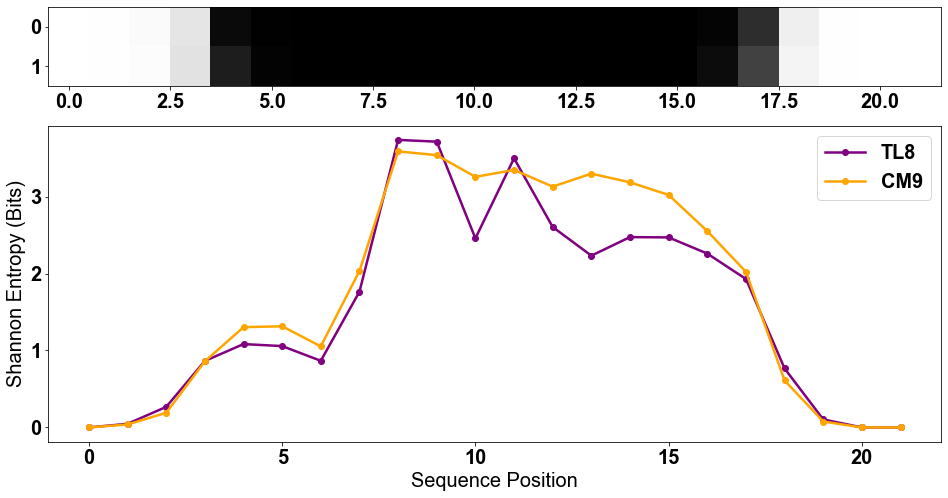

In [25]:
# Calculate the Shannon Entropy, a proxy for diversity

# If we want error bars for these, we need to bootstrap the error bars,
# THEN permutation test to get the significance of the differences...

####################################################################
# New for version 0.8! Add stdev based on boostrapping procedures
bootstrap = False
boots = 1000
####################################################################

fig = pl.figure(figsize=(16,8))
gs = gridspec.GridSpec(2, 1,height_ratios=[1,4])

ax1 = pl.subplot(gs[0])
ax2 = pl.subplot(gs[1])

poses = len(seq_MIf)
entropy = []; frequencies = []; coverage=[]
for dat in np.arange(len(sub_sels)):
    temp_MI = sub_matF[ref_sub[ref_sub[len(sub_matF)-1] == dat].index].iloc[0:-1]
    if bootstrap:
        boot_entropy = []; boot_frequencies = []; boot_cov = []
        for i in np.arange(boots):
            re_MI = resample(np.transpose(np.array(temp_MI)))
            entropy_pre,freq_pre,cov_pre = aims.calculate_shannon(re_MI)
            boot_entropy.append(entropy_pre); boot_frequencies.append(freq_pre)
            boot_cov.append(cov_pre)
        ent_avg = np.average(boot_entropy,axis=0)
        ent_std = np.std(boot_entropy,axis=0)
        freq_avg = np.average(boot_frequencies,axis=0)
        cov_avg = np.average(boot_cov,axis=0)
        ax2.plot(ent_avg,marker='o',linewidth=2.5,color=colors[dat])
        pl.fill_between(np.arange(len(ent_avg)),ent_avg+ent_std,ent_avg-ent_std,alpha=0.3,color=colors[dat])
        entropy.append(ent_avg); frequencies.append(freq_avg); coverage.append(1-cov_avg)
    else:
        entropy_pre,freq_pre,cov_pre = aims.calculate_shannon(np.transpose(np.array(temp_MI)))
        ax2.plot(entropy_pre,marker='o',linewidth=2.5,color=colors[dat])
        entropy.append(entropy_pre); frequencies.append(freq_pre); coverage.append(1-cov_pre)

ax1.imshow(coverage,aspect='auto',interpolation='nearest',cmap='Greys')

pl.legend(label); pl.xlabel('Sequence Position'); pl.ylabel('Shannon Entropy (Bits)')

if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax2.plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,4.2,100),'black',linewidth = 3)
pl.savefig(outputDir+'/AIMS_entropy.pdf',format='pdf')

# Section 14.1 Statistical Significance of Entropy Calculations
Similar to the position-sensitive biophysical property statistical significance above

# NOTE: The remaining statistical significance calculations get progressively slower. Not recommended for exploratory data analysis

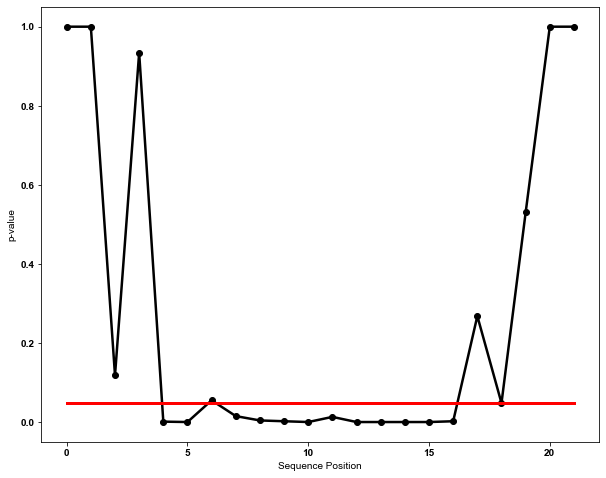

In [27]:
data1 = sub_matF[ref_sub[ref_sub[len(sub_matF)-1] == 0].index].iloc[0:-1]
data2 = sub_matF[ref_sub[ref_sub[len(sub_matF)-1] == 1].index].iloc[0:-1]
p_ent = aims.do_statistics(data1,data2,num_reps=1000,test='function',test_func=aims.calculate_shannon,func_val = 0)

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(10,8))
pl.plot(p_ent,color='black',marker='o',linewidth=2.5)
pl.plot(np.arange(len(p_ent)),np.ones(len(p_ent))*0.05,color='red',linewidth=3)

pl.xlabel('Sequence Position')
pl.ylabel('p-value')

pl.savefig(outputDir+'/aims_entropy_pval.pdf',format='pdf')

# Section 14.2 Mutual Information Calculations
NOTE: The Mutual Information Calculation Can Be Quite Slow. Especially the case for MSAs with many amino acids. 

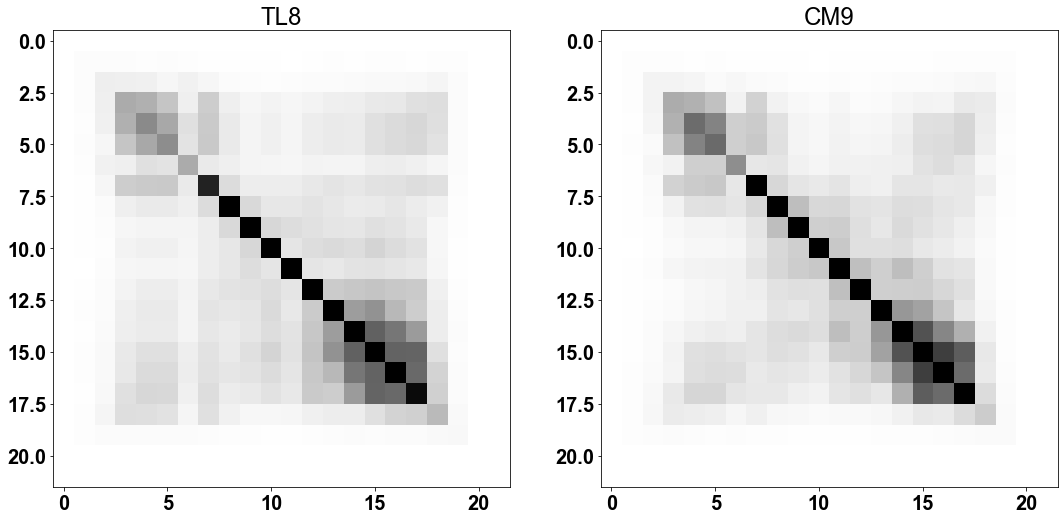

In [26]:
# And then the mutual information:
fig, ax = pl.subplots(1, len(sub_sels),squeeze=False,figsize=(18,5*len(sub_sels)))

poses = len(seq_MIf)
MI = []; ent_cond = []; count = []
for dat in np.arange(len(sub_sels)):
    temp_MI = sub_matF[ref_sub[ref_sub[len(sub_matF)-1] == dat].index].iloc[0:-1]
    MI_pre,ent_cond_pre,count_pre = aims.calculate_MI(np.transpose(np.array(temp_MI)))
    ax[0,dat].imshow(MI_pre,vmin=0,vmax=2,cmap=cm.Greys)
    MI.append(MI_pre); ent_cond.append(ent_cond_pre); count.append(count_pre)
    ax[0,dat].set_title(label[dat])

#pl.colorbar(x)
# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        for j in np.arange(len(sub_sels)):
            ax[0,j].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses,100),'black',linewidth = 3)
            ax[0,j].plot( np.linspace(0,poses,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

pl.savefig(outputDir+'/AIMS_MI.pdf',format='pdf')

# Section 14.3 Position-Sensitive Amino Acid Frequencies
Note: Need to have run Shannon Entropy Calculation first

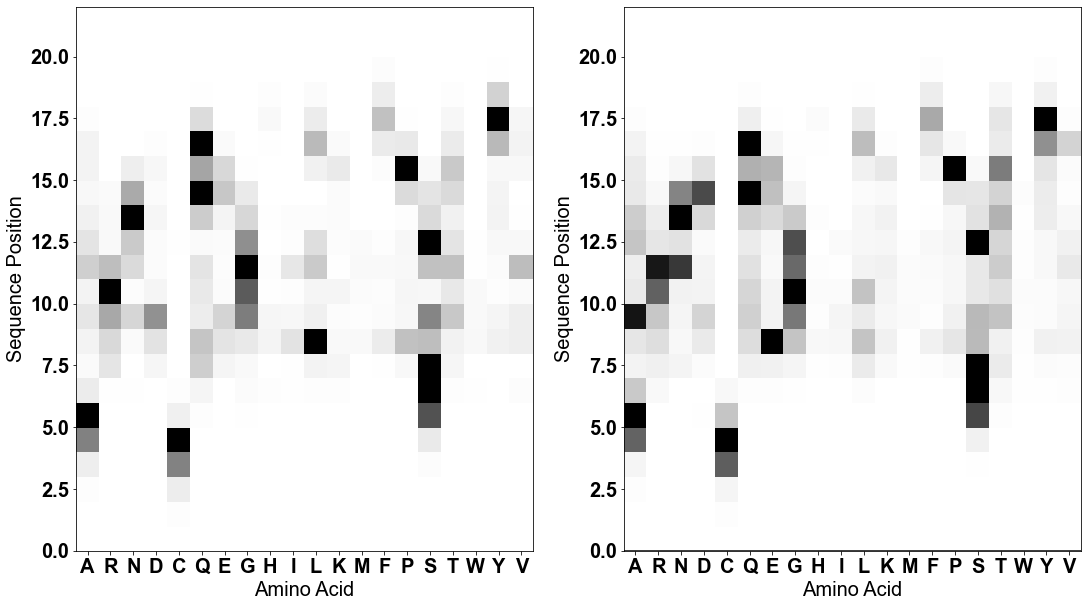

In [27]:
# Calculate the probabilities of seeing each amino acid at each position
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(18,10))
#pl.title(str(label[0])+ ' AA Frequency - ' + str(label[1]) + ' AA Frequency')

AA_key=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']

freq1 = pandas.DataFrame(frequencies[0][:,1:])
freq2 = pandas.DataFrame(frequencies[1][:,1:])
# Remember that the "frequencies" are calculated with your custom
# key in mind! So you need to carry that down here
if custom_key:
    freq1.columns = my_AA_key
    freq2.columns = my_AA_key 
    fin_key = my_AA_key
else:
    freq1.columns = AA_key
    freq2.columns = AA_key
    fin_key = AA_key

x=ax[0,0].pcolormesh(freq1,vmin=0,vmax=0.25,cmap=cm.Greys)
x=ax[0,1].pcolormesh(freq2,vmin=0,vmax=0.25,cmap=cm.Greys)

#pl.colorbar(x); pl.ylabel('Sequence Position')
xax=pl.setp(ax,xticks=np.arange(20)+0.5,xticklabels=fin_key)

place=0
if type(mat_size) == int:
    pl.plot(np.arange(21),place*np.ones(21),'black')
else:
    for i in mat_size:
        place += i
        ax[0,0].plot(np.arange(21),place*np.ones(21),'black')
        ax[0,1].plot(np.arange(21),place*np.ones(21),'black')

ax[0,0].set_xlabel("Amino Acid")
ax[0,1].set_xlabel("Amino Acid")
ax[0,0].set_ylabel("Sequence Position")
ax[0,1].set_ylabel("Sequence Position")

#pl.colorbar(x)
pl.savefig(outputDir+'/AIMS_freq_sides.pdf',format='pdf')

# Section 15: Binary Comparisons Between Datasets
Anything from here on requires a comparison between only two datasets. This can be two clusters, two loaded in files, two metadata subsets, whatever.

You can continue on from the previous sections even if you were analyzing multiple datasets. The analysis will just, by default, compare only the first two datasets

# Section 15.1: Mutual Information Difference

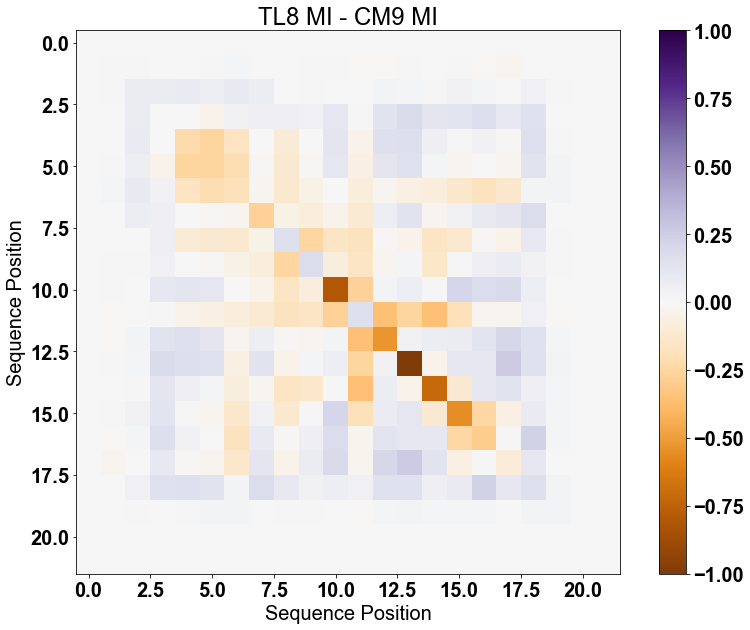

In [28]:
# A bit easier to look at the DIFFERENCE in mutual information:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
x = pl.imshow(MI[0] - MI[1], cmap=cm.PuOr, vmin = -1, vmax = 1)
pl.colorbar(x); pl.title(str(label[0])+ ' MI - ' + str(label[1]) + ' MI')

# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot((mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses,100),'black',linewidth = 3)
        ax[0,0].plot( np.linspace(0,poses,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

pl.xlabel('Sequence Position'); pl.ylabel('Sequence Position')
pl.savefig(outputDir+'/AIMS_MIdiff.pdf',format='pdf')

# Section 15.2 Mutual Information Statistical Significance

# NOTE: This calculation is EXTREMELY SLOW. The slowest of everything in this notebook. 

While a high num_reps should be used to be statistically sound, the mutual information calculation is repeated for *every* permutation. At 8 seconds per 500 sequences and 2 CDR loops, that scales pretty poorly. Will need to introduce parallelization here at some point 

# Num_reps is set to 10 by default, but this is almost certainly not enough permutations in any application

Note: we again change the way we represent statistical significance for easier interpretation. Rather than show every p-value in the matrix, which can be hard to read, set a binary threshold alpha and only visualize those points with p < alpha

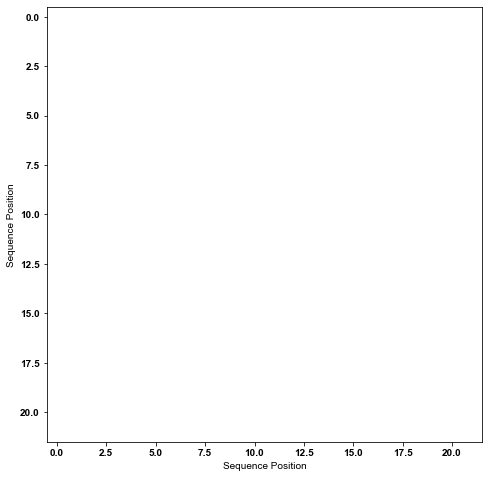

In [31]:
data1 = sub_matF[ref_sub[ref_sub[len(sub_matF)-1] == 0].index].iloc[0:-1]
data2 = sub_matF[ref_sub[ref_sub[len(sub_matF)-1] == 1].index].iloc[0:-1]
p_MI = aims.do_statistics(data1,data2,num_reps=10,test='function',test_func=aims.calculate_MI,func_val = 0)

dim1, dim2 = np.shape(p_MI)
alpha = 0.05

empty_mat_mi = np.zeros((dim1,dim2))
for a in np.arange(dim1):
    for b in np.arange(dim2):
        if p_MI[a,b] < alpha:
            empty_mat_mi[a,b] = 1

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(10,8))

x= pl.imshow(empty_mat_mi,cmap=cm.Greys)
pl.xlabel('Sequence Position')
pl.ylabel('Sequence Position')

pl.savefig(outputDir+'/AIMS_MIdiff_sig.pdf',format='pdf')

# Section 15.3: Position-Sensitive Amino Acid Frequency Difference

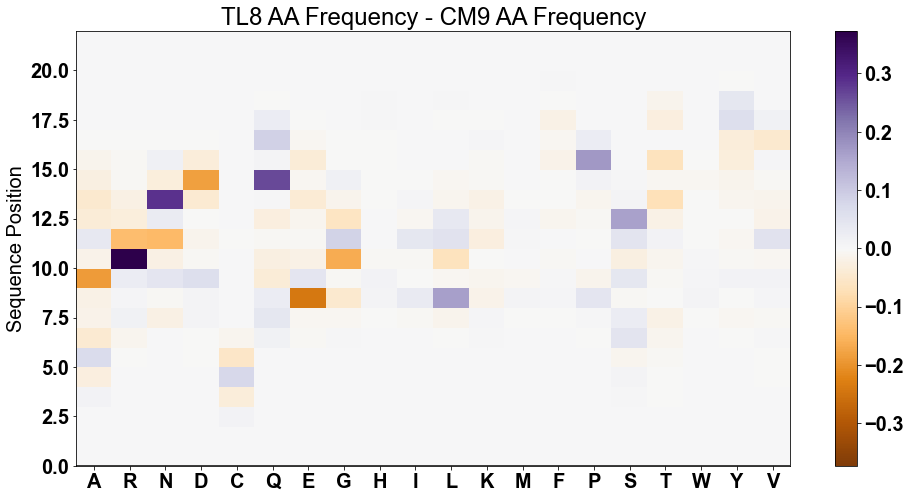

In [29]:
# Calculate the probabilities of seeing each amino acid at each position
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
pl.title(str(label[0])+ ' AA Frequency - ' + str(label[1]) + ' AA Frequency')
freqMax = np.max(freq1.values-freq2.values); freqMin = np.min(freq1.values-freq2.values)
freqBound = max(abs(freqMax),abs(freqMin))

x=ax[0,0].pcolormesh(freq1-freq2,vmin=-freqBound,vmax=freqBound,cmap=cm.PuOr)
AA_key=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
pl.colorbar(x); pl.ylabel('Sequence Position')
xax=pl.setp(ax,xticks=np.arange(20)+0.5,xticklabels=fin_key)

place=0
if type(mat_size) == int:
    pl.plot(np.arange(21),place*np.ones(21),'black')
else:
    for i in mat_size:
        place += i
        pl.plot(np.arange(21),place*np.ones(21),'black')

pl.savefig(outputDir+'/AIMS_freqDiff.pdf',format='pdf')

# Section 15.4 Position-Sensitive Amino Acid Frequency Difference Statistical Significance

Note, we again change the way we represent statistical significance for easier interpretation. Rather than show every p-value in the matrix, which can be hard to read, set a binary threshold alpha and only visualize those points with p < alpha

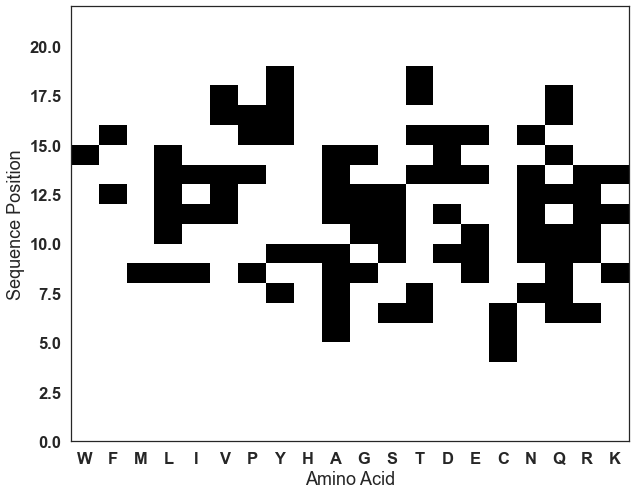

In [47]:
data1 = sub_matF[ref_sub[ref_sub[len(sub_matF)-1] == 0].index].iloc[0:-1]
data2 = sub_matF[ref_sub[ref_sub[len(sub_matF)-1] == 1].index].iloc[0:-1]
p_freq = aims.do_statistics(data1,data2,num_reps=1000,test='function',test_func=aims.calculate_shannon,func_val = 1)

dim1, dim2 = np.shape(p_freq)
alpha = 0.05

AA_key=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']

empty_mat = np.zeros((dim1,dim2))
for a in np.arange(dim1):
    for b in np.arange(dim2):
        if p_freq[a,b] < alpha:
            empty_mat[a,b] = 1

# Need stuff to optionally shift around the x-axis:
empty_frame = pandas.DataFrame(empty_mat[:,1:])
if custom_key:
    empty_frame.columns = my_AA_key
else:
    empty_frame.columns = AA_key

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(10,8))
x = pl.pcolormesh(empty_frame,cmap=cm.Greys)
xax=pl.setp(ax,xticks=np.arange(20)+0.5,xticklabels=fin_key)
pl.ylabel('Sequence Position')
pl.xlabel('Amino Acid')
pl.savefig(outputDir+'/aa_diff_statSig.pdf',format='pdf')

# Section 16: Linear Discriminant Analysis

Classification Accuracy
0.7303834808259587


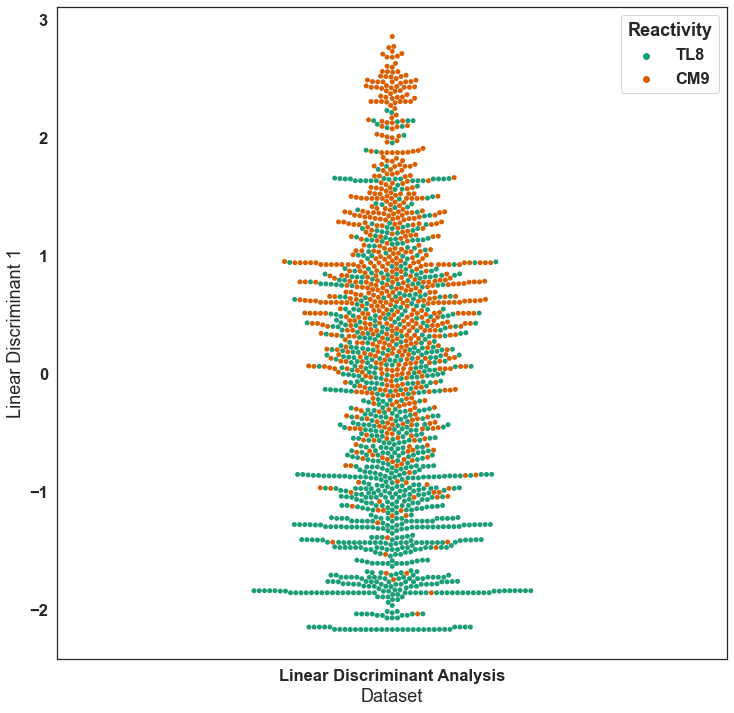

In [48]:
bigass1 = full_big_re.loc[ref_sub[ref_sub[len(sub_matF)-1] == 0].index]
seq1_len = len(bigass1)
bigass1.index = np.arange(seq1_len)
bigass2 = full_big_re.loc[ref_sub[ref_sub[len(sub_matF)-1] == 1].index]
seq2_len = len(bigass2)
bigass2.index = np.arange(seq2_len)

######### Run the actual classification here ###############
# Change the matSize variable to alter the number of vectors used to generate a classification
bigF,weights,acc_all,mda_all,final,top_names = classy.do_linear_split(bigass1,bigass2,got_big=True,matSize=10)
############################################################

import seaborn as sns
fig = pl.figure(figsize = (12, 12))
dset = ["Linear Discriminant Analysis" for x in range(seq1_len+seq2_len)]
reacts = [label[0] for x in range(seq1_len)] + [label[1] for x in range(seq2_len)]

d1 = {'Dataset': dset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
    'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)
sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")
print("Classification Accuracy")
print(acc_all)
pl.savefig(outputDir+'/AIMS_LDA.pdf',format='pdf')

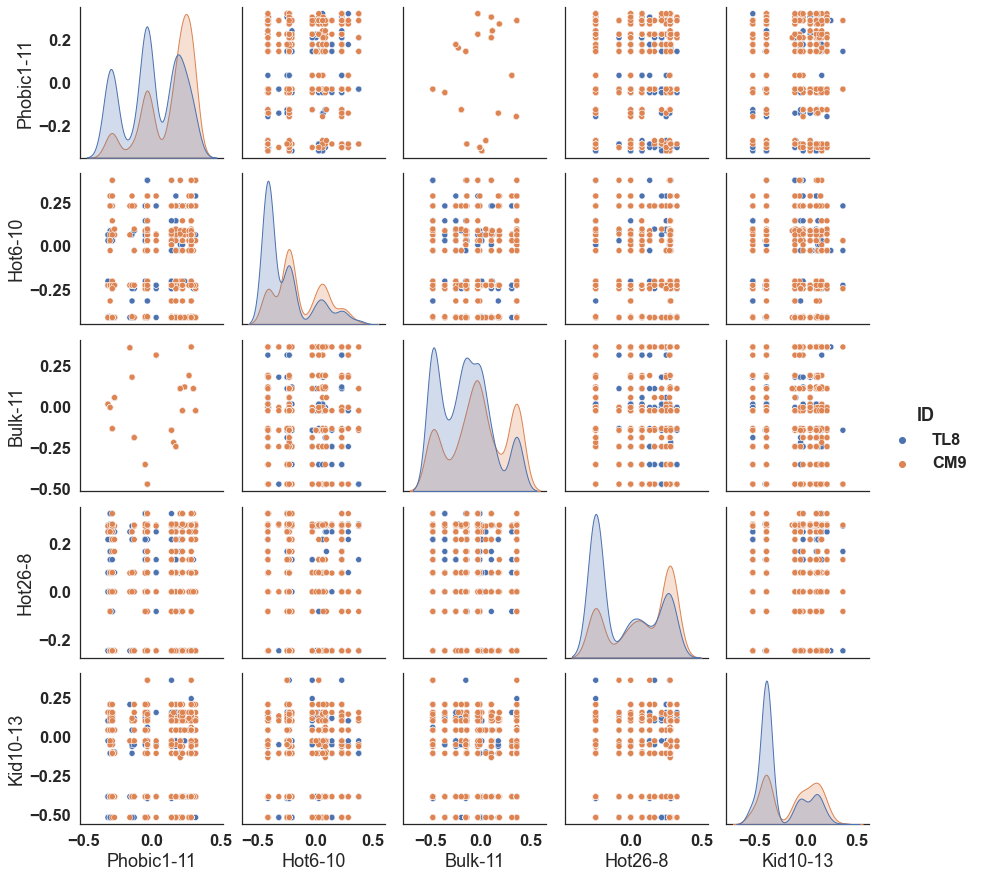

In [49]:
# Show the top properties that differentiate the two populations
# show_top = how many of these top values do you want to show? don't recommend more than ~5
# solely due to how busy the figure gets
# Again, see eLife paper for biophysical property definitions
import seaborn as sns
show_top = 5
dset_parse = final[top_names[0:show_top]]
dset_ID_pre1 = bigF['ID']
dset_ID_pre2 = dset_ID_pre1.replace(1.0,label[0])
dset_ID = dset_ID_pre2.replace(2.0,label[1])

bigass_parse_dset = pandas.concat([dset_parse,dset_ID],axis = 1)
sns.pairplot(bigass_parse_dset,hue = 'ID')
pl.savefig(outputDir+'/AIMS_pairplot.pdf',format='pdf')

# Section 17: Detailed Amino Acid Frequency Breakdowns
This feature is most useful in peptide analysis, but could be useful for general repertoire comparisons

# Section 17.1: Amino Acid Frequency

Different from the frequency before because this is position-independent

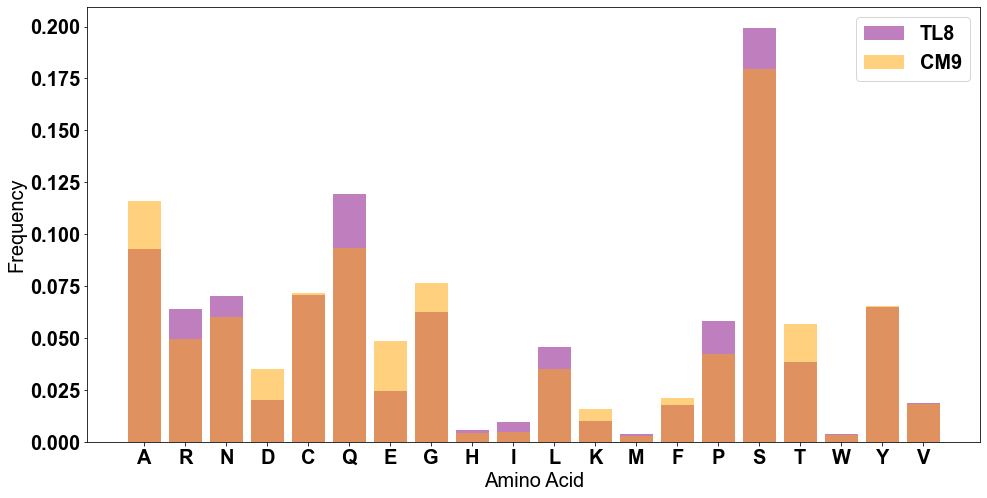

In [30]:
# Need to get back just our sequences of interest.
seq1 = sub_seqF.loc[ref_sub[ref_sub[len(sub_matF)-1] == 0].index]
seq2 = sub_seqF.loc[ref_sub[ref_sub[len(sub_matF)-1] == 1].index]
# Calculate both position-insensitive amino acid frequency and digram frequencies
# Can either normalize to the # of sequences or total number of AA (num_seq or num_AA)
AA_freq_all1, digram_all1 = aims.full_AA_freq(seq1,norm='num_AA')
AA_freq_all2, digram_all2 = aims.full_AA_freq(seq2,norm='num_AA')

freqAll1 = np.transpose(pandas.DataFrame(AA_freq_all1))
freqAll1.columns = AA_key
freqAll2 = np.transpose(pandas.DataFrame(AA_freq_all2))
freqAll2.columns = AA_key

freqAll1_df = freqAll1[fin_key]
freqAll2_df = freqAll2[fin_key]

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
ax[0,0].bar(np.arange(len(AA_freq_all1)),freqAll1_df.values[0], color=colors[0],alpha=0.5)
ax[0,0].bar(np.arange(len(AA_freq_all2)),freqAll2_df.values[0],color=colors[1],alpha=0.5)
xax=pl.setp(ax,xticks=np.arange(20),xticklabels=fin_key)
ax[0,0].legend([label[0],label[1]])
#ax[1,0].legend([label[2],label[3]])2
pl.ylabel('Frequency')
pl.xlabel('Amino Acid')
pl.savefig(outputDir+'/AIMS_AAnetProb.pdf',format='pdf')

# Section 17.2: Statistical Significance for Amino Acid Frequencies

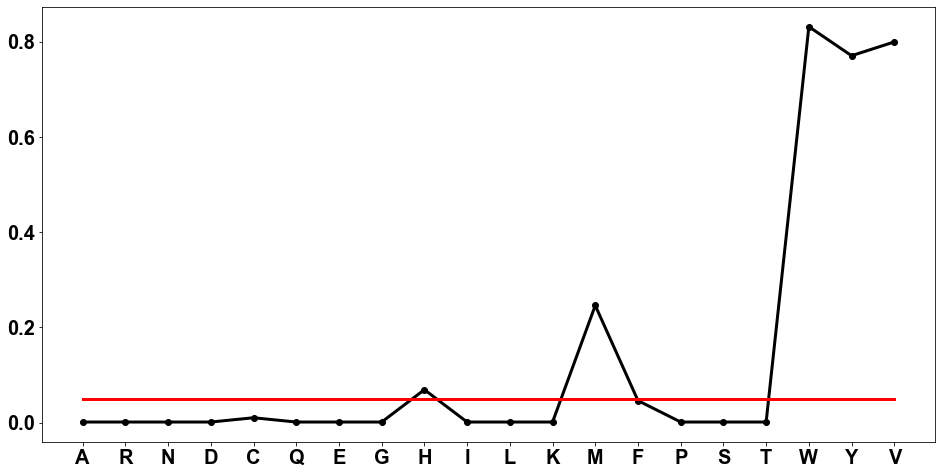

In [31]:
data1 = seqF[ref_sub[ref_sub[len(sub_matF)-1] == 0].index]
data2 = seqF[ref_sub[ref_sub[len(sub_matF)-1] == 1].index]

p_freq = aims.do_statistics(data1,data2,num_reps=1000,test='function',test_func=aims.full_AA_freq,func_val = 0)

p_df = np.transpose(pandas.DataFrame(p_freq))
p_df.columns = AA_key
p_df_fin = p_df[fin_key]

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
pl.plot(p_df_fin.values[0],marker='o',linewidth=3,color='black')
pl.plot(np.arange(20),np.ones(20)*0.05,linewidth=3,color='red')
xax=pl.setp(ax,xticks=np.arange(20),xticklabels=fin_key)
pl.savefig(outputDir+'/AIMS_AAnetProb_pval.pdf',format='pdf')

# Section 17.3 Plot the Digram Frequencies Per Sequence (or per AA)
There can occasionally be interesting information in these digram patterns, particularly if there are notabe differences between populations.

Note, while the matrix could possibly appear symmetric, it need not be so. The y-axis gives the first amino acid in the digram, the x-axis gives the second. So on the x,y coordinate map, E (x-axis) and D (y-axis) gives the frequency of the digram DE.

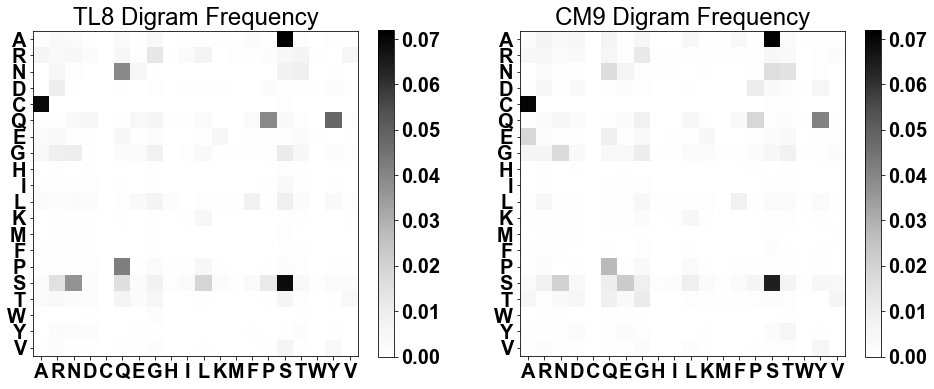

In [33]:
fig, ax = pl.subplots(int(len(label)/2), 2,squeeze=False,figsize=(16,12))
plot_max = np.max([np.max(digram_all1),np.max(digram_all2)])

ax[0,0].set_title(str(label[0])+ ' Digram Frequency')
ax[0,1].set_title(str(label[1])+ ' Digram Frequency')

# Again for potentially altering the AA axis how you want:
digAll1 = pandas.DataFrame(digram_all1)
digAll1.columns = AA_key; digAll1.index = AA_key
digAll2 = pandas.DataFrame(digram_all2)
digAll2.columns = AA_key; digAll2.index = AA_key

digF1 = digAll1[fin_key].loc[fin_key]
digF2 = digAll2[fin_key].loc[fin_key]

x1 = ax[0,0].imshow(digF1,  cmap = cm.Greys,vmin=0,vmax=plot_max)
x2 = ax[0,1].imshow(digF2,  cmap = cm.Greys,vmin=0,vmax=plot_max)

xax=pl.setp(ax[0,0],xticks=np.arange(20),xticklabels=fin_key)
yax=pl.setp(ax[0,0],yticks=np.arange(20),yticklabels=fin_key)
xax=pl.setp(ax[0,1],xticks=np.arange(20),xticklabels=fin_key)
yax=pl.setp(ax[0,1],yticks=np.arange(20),yticklabels=fin_key)

fig.colorbar(x1, ax=ax[0, 0], shrink=0.5)
fig.colorbar(x2, ax=ax[0, 1], shrink=0.5)
pl.savefig(outputDir+'/AIMS_digram_sep.pdf',format='pdf')

# Section 17.4 Digram Amino Acid Differences

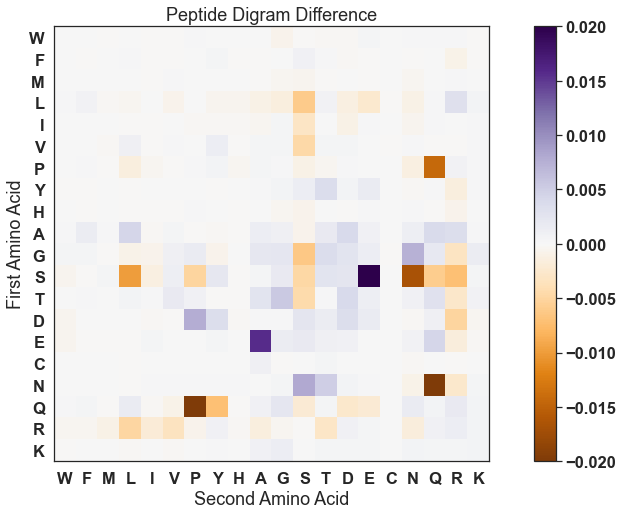

In [39]:
# Look at the difference in these digram frequencies
# For now, hard to say if these are necessarily significant, 
# more downstream analysis is needed to tease out conclusions
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
pl.title('Peptide Digram Difference')
min_temp = np.min(digram_all2-digram_all1)
max_temp = np.max(digram_all2-digram_all1)
if abs(min_temp) > abs(max_temp):
    propMin = min_temp
    propMax = -min_temp
elif abs(max_temp) > abs(min_temp):
    propMin = -max_temp
    propMax = max_temp
else:
    propMin = min_temp
    propMax = max_temp
zzz = pl.imshow(digF1-digF2, vmin = propMin, vmax = propMax, cmap = cm.PuOr)
xax=pl.setp(ax,xticks=np.arange(20),xticklabels=fin_key)
yax=pl.setp(ax,yticks=np.arange(20),yticklabels=fin_key)
ax[0,0].set_ylabel('First Amino Acid')
ax[0,0].set_xlabel('Second Amino Acid')
pl.colorbar(zzz)
pl.savefig(outputDir+'/AIMS_digramDiff.pdf',format='pdf')

# Section 17.5: Digram Amino Acid Difference Stat. Sig.

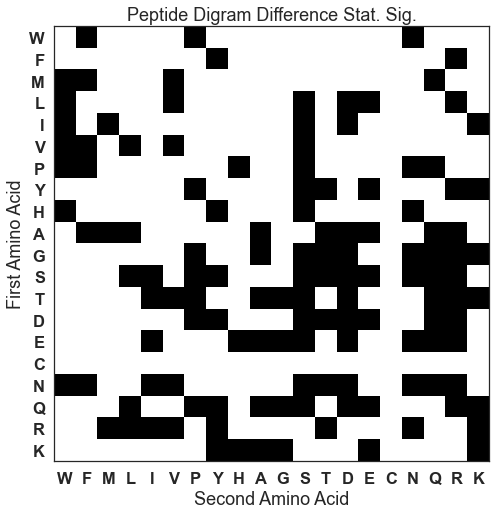

In [40]:
data1 = seqF[ref_sub[ref_sub[len(sub_matF)-1] == 0].index]
data2 = seqF[ref_sub[ref_sub[len(sub_matF)-1] == 1].index]

p_digram = aims.do_statistics(data1,data2,num_reps=1000,test='function',test_func=aims.full_AA_freq,func_val = 1)

dim1, dim2 = np.shape(p_digram)
alpha = 0.05

empty_mat_digram = np.zeros((dim1,dim2))
for a in np.arange(dim1):
    for b in np.arange(dim2):
        if p_digram[a,b] < alpha:
            empty_mat_digram[a,b] = 1

fin_key = my_AA_key

empty_dig = pandas.DataFrame(empty_mat_digram)
empty_dig.columns = AA_key; empty_dig.index = AA_key
empty_digF = empty_dig[fin_key].loc[fin_key]

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(10,8))
pl.title('Peptide Digram Difference Stat. Sig.')
x= pl.imshow(empty_digF,cmap=cm.Greys)
xax=pl.setp(ax,xticks=np.arange(20),xticklabels=fin_key)
xax=pl.setp(ax,yticks=np.arange(20),yticklabels=fin_key)
ax[0,0].set_ylabel('First Amino Acid')
ax[0,0].set_xlabel('Second Amino Acid')
pl.savefig(outputDir+'/digram_diff_sig.pdf',format='pdf')